# Analyse et prediction des prix de biens immobiliers

Dans ce projet, nous explorerons un jeu de donnees immobilieres annotes d'un total de 80 parametres afin de constituer un model de prediction du prix de vente d'ume maison. 


L'etude se scindera en plusieus parties:

## 1) Lecture, etude des donnes et selection (EDA: Explanatory Data Analysis)

- Cette etape vise a comprendre les donnees que nous manipulerons afin d'orienter certaines de nos decisons futures: est-ce que toutes les donnees sont reelement utile afin de dresser un modele suffisamment general (nous voulons eviter le surapprentissage)
- Certaines donnes peuvent etre informe ou erronees, cette etape nous permettra de penser a des solutions d'encodage des donnees a traiter (one-hot / label encoding)
- Nous voulons aussi mesurer la distribution des prix (nous etudierons les metriques classiques de distribution aleatoires. Quelle pourrait etre la loi de distribution adequate pour modeliser la distribution des prix ? Est-ce une loi normale ? Si oui, pouvons nous etudie son asymetrie et son applatissement ? etc.)
- A la suite de ces analyses, nous pourront selectionner les parametres les plus efficaces (feature selection) necessaire a l'entrainement de notre modele.
    
## 2) Nettoyage des donnees, "feature engineering" et annotation

- Nous eliminerons les valeurs aberrantes et celles pouvant etre considerees comme "nulle"
- En reflection a l'etude precedente, nous elimiinerons les valeurs dites 'asymetriques'
- Certaines valeurs sont non numerique et necessiteront un encodage (LabelEncoder/OneHotEncoder). Quel est le meilleur encodage ? Une approche hybride est-elle souhaitable ?
    
## 3) Machine learning

- Nous adopterons une strategie consistant a selectionner plusieurs modeles, etablir leurs hyper parametres (nous utiliserons la "recherche de grille" pour determiner les valeurs pouvant mener au meilleurs resultats)
- Nous opererons une "validation croisee" de notre modele afin de valider la robustesse de notre modele (ce faisant nous reduirons aussi la variance de notre metrique de performance en moyenant nos resultat sur plusieurs decoupages du jeu de validation).
- Entrainement: les hyper parametres seront adaptes avec la recheche par grille et la validation croisee.
- Nous evaluerons nos resultat et choisirons le modele le plus adapate. Et nous essaierons d'adopter une approche hybride en combinant differents modeles afin de generer un "meta" modele.
    
## 4) Tester le modele

- Nous utiliserons le jeu de donnees de test afin de mesurer les performances finales du modele choisi.


# Bibliotheques utilisees

* **pandas**, **numpy**: manipulations des donnees.
* **matplotlib.pyplot**, **seaborn**: visualisation des donnees
* **sklearn**: algorithmes et fonctions utilitaires liees a la regression du jeu de donnees. On importera egalement les metriques mecessaires a l'evaluation du modele choisi.
* **xgboost** : bibliotheque specialisee dans l'approche par "gradient boosting" (nous comparerons cette approche avec les plus traditionelles basees sur des arbres de decisions)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [4]:
train = pd.read_csv('data/train.csv')
train, test = train_test_split(train, test_size=0.3, random_state=42)

Commencons par inspecter les donnees. 

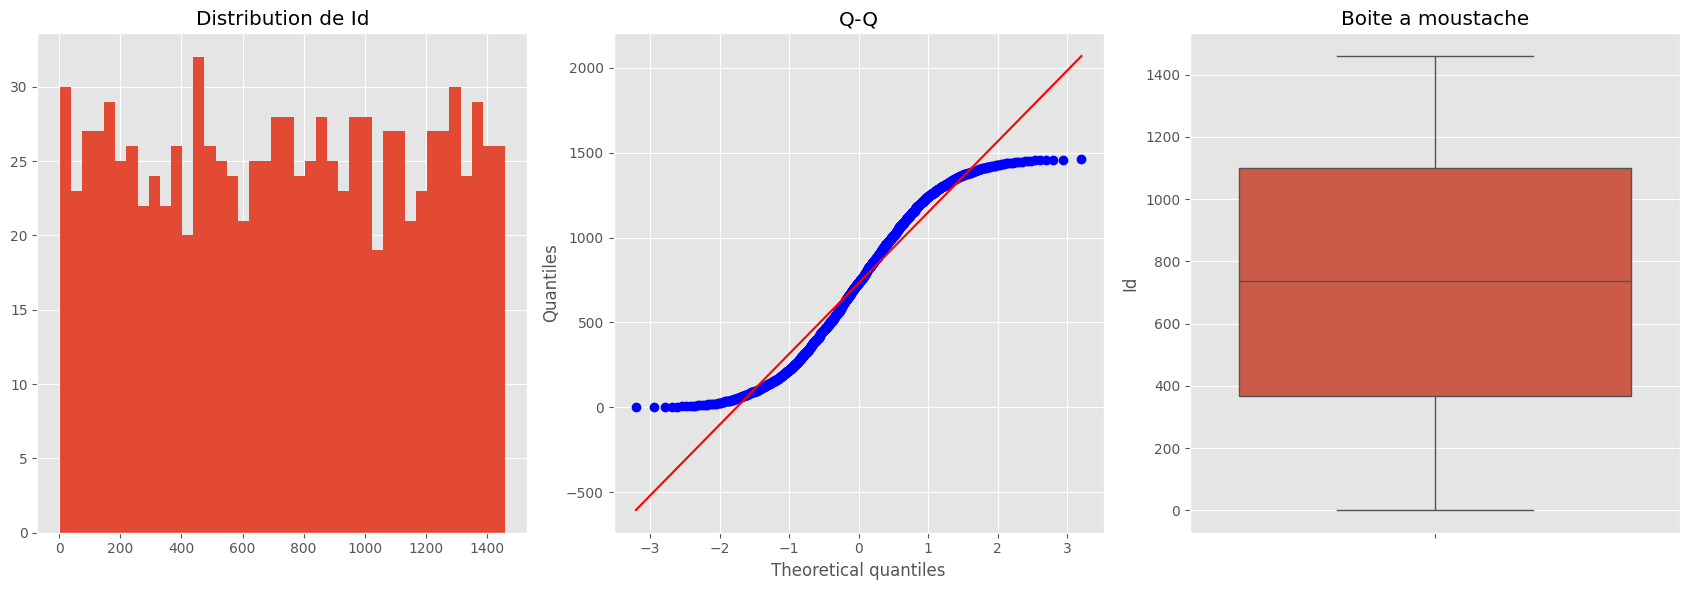

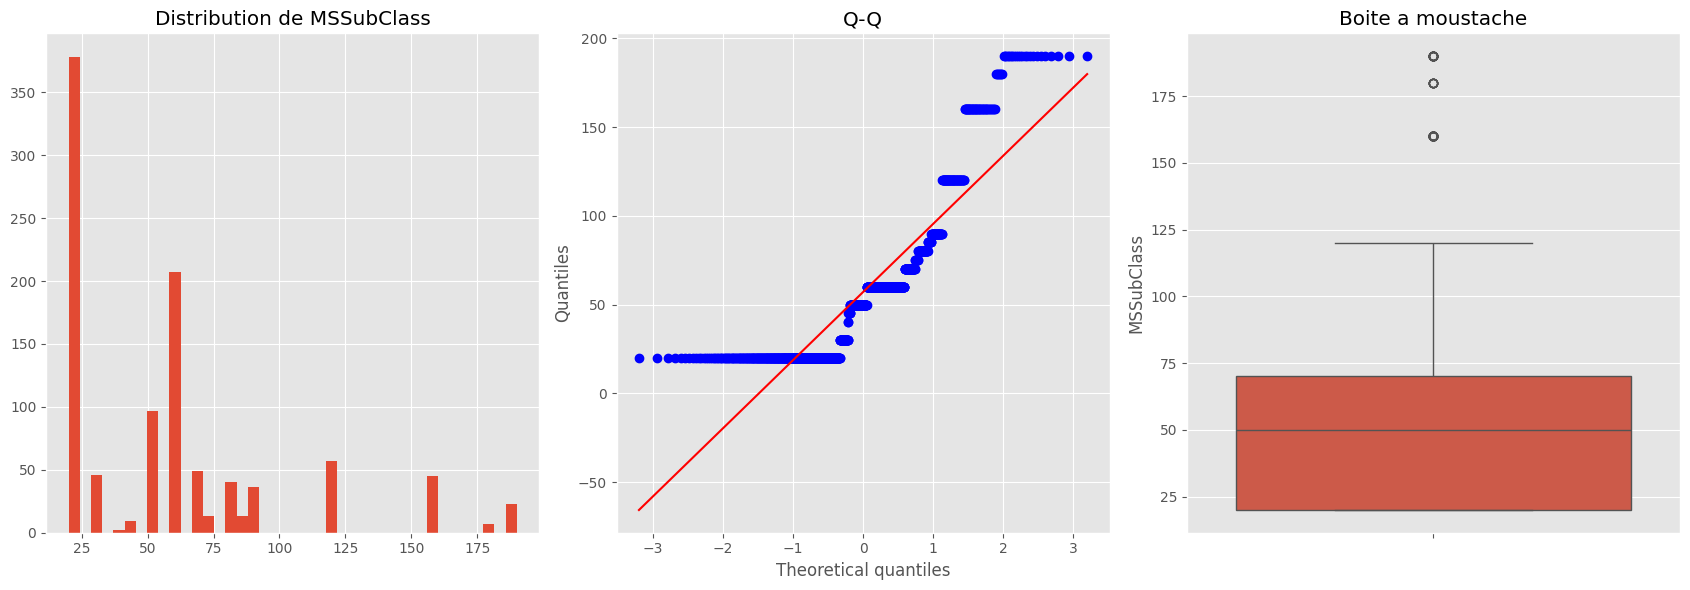

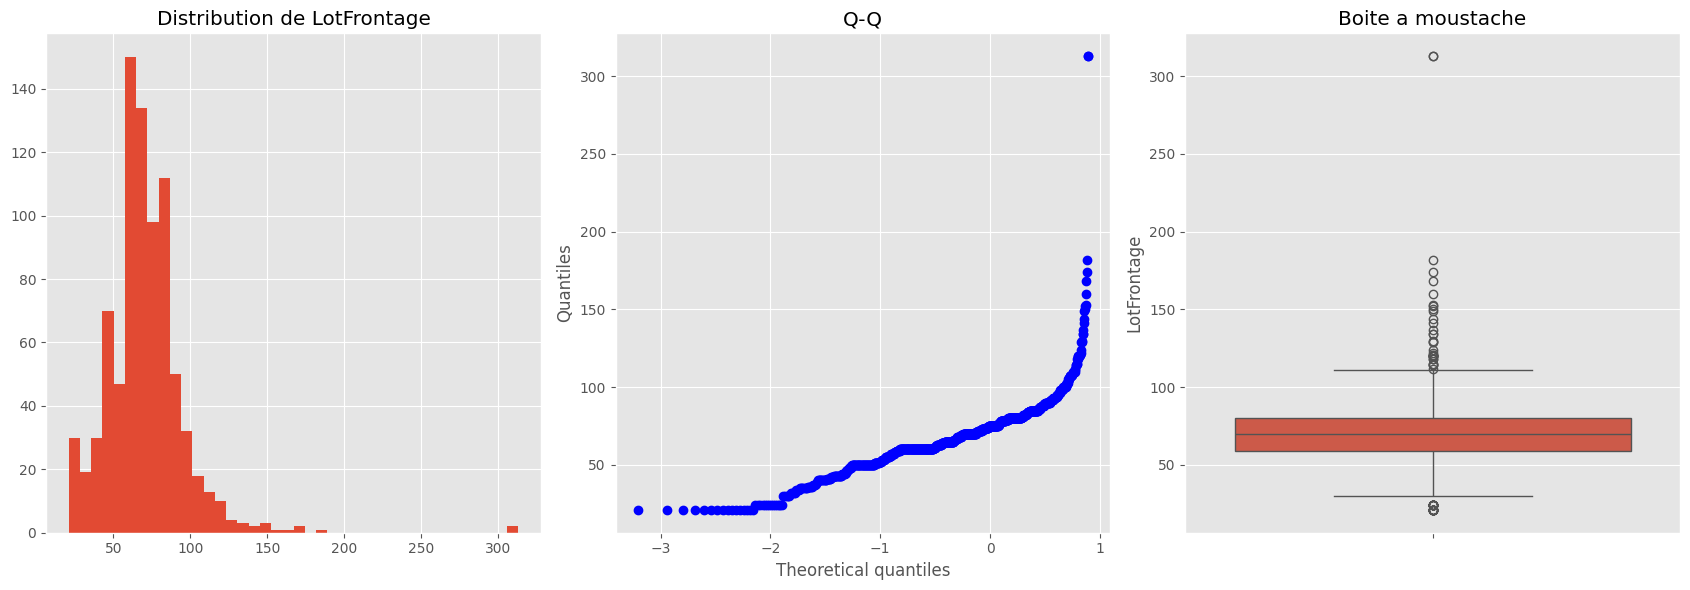

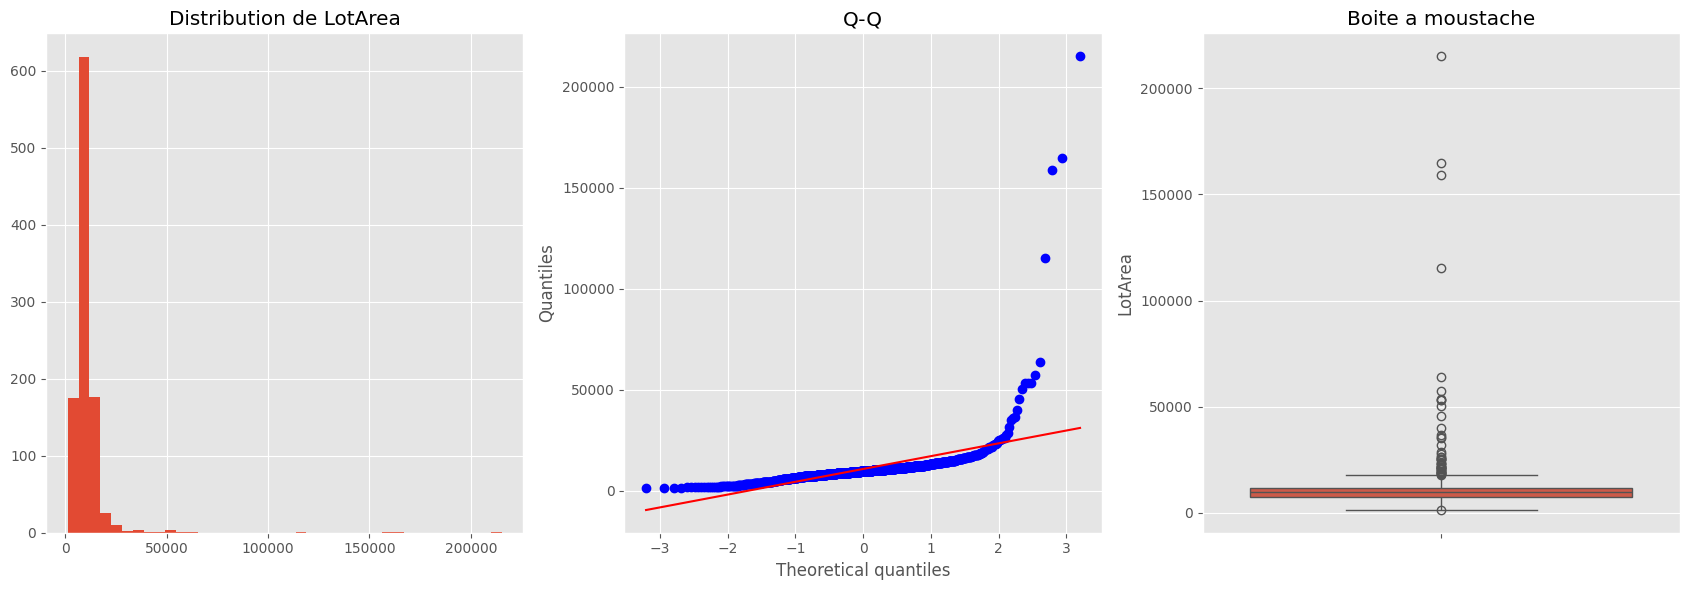

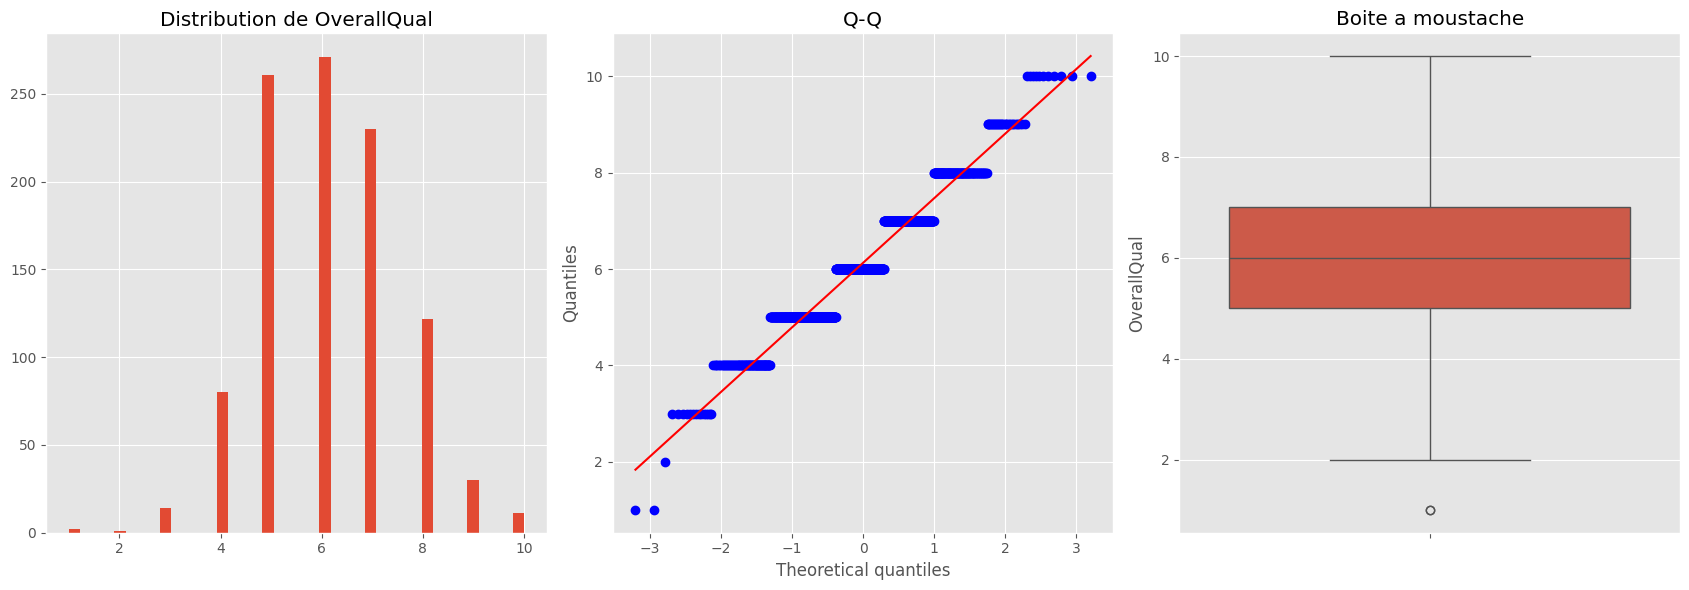

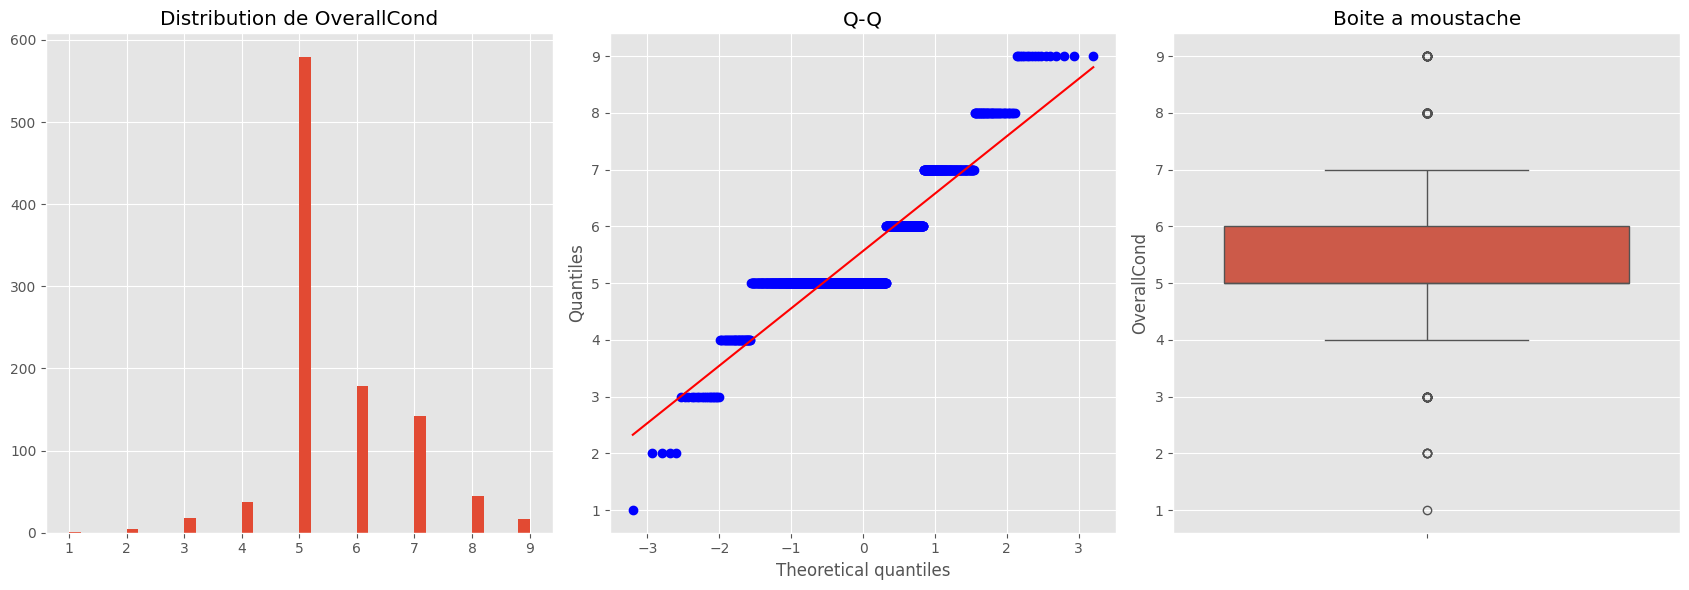

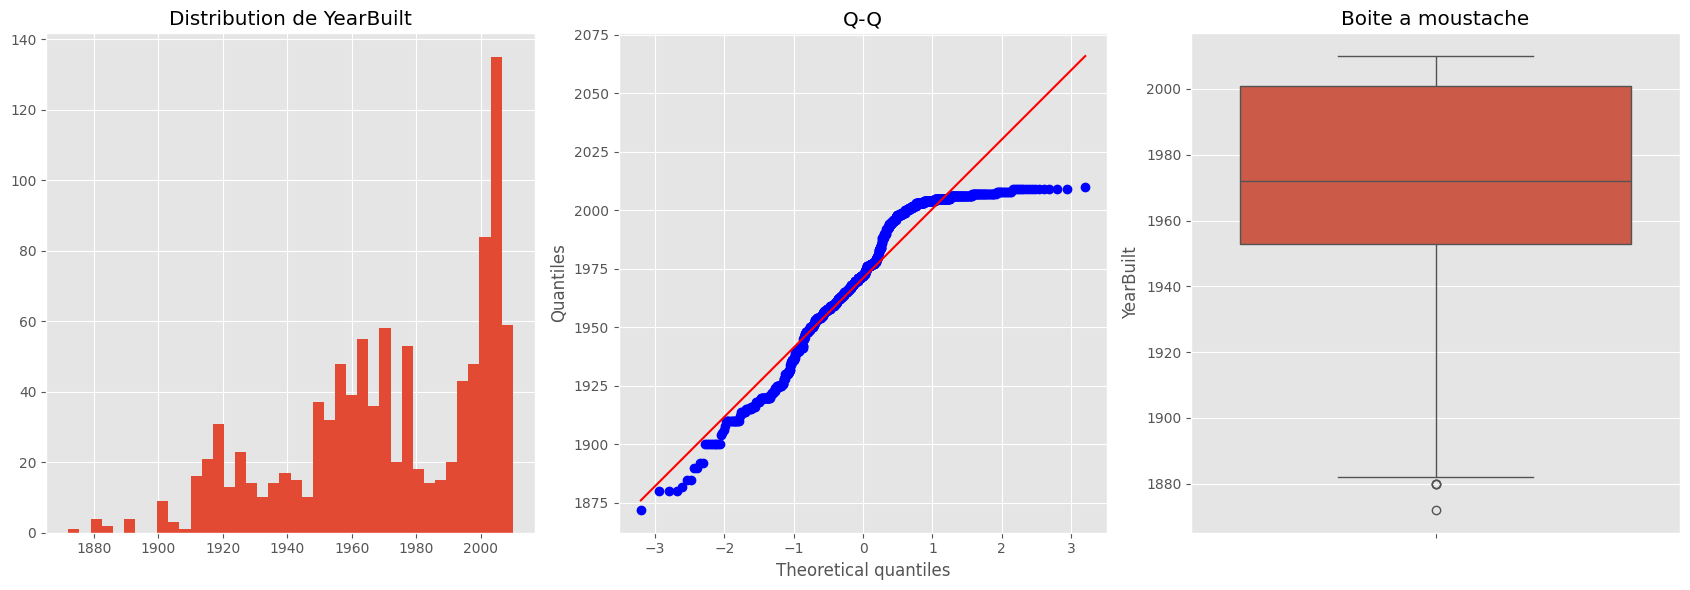

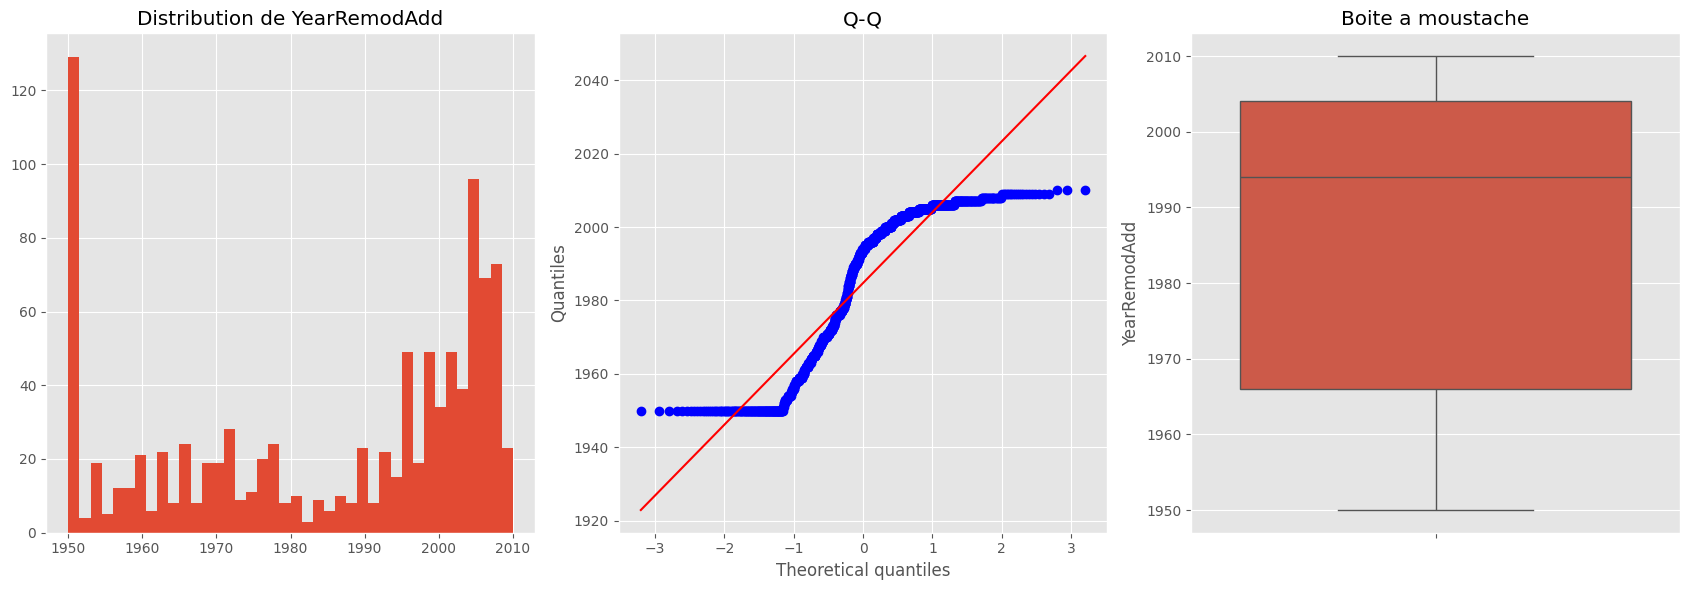

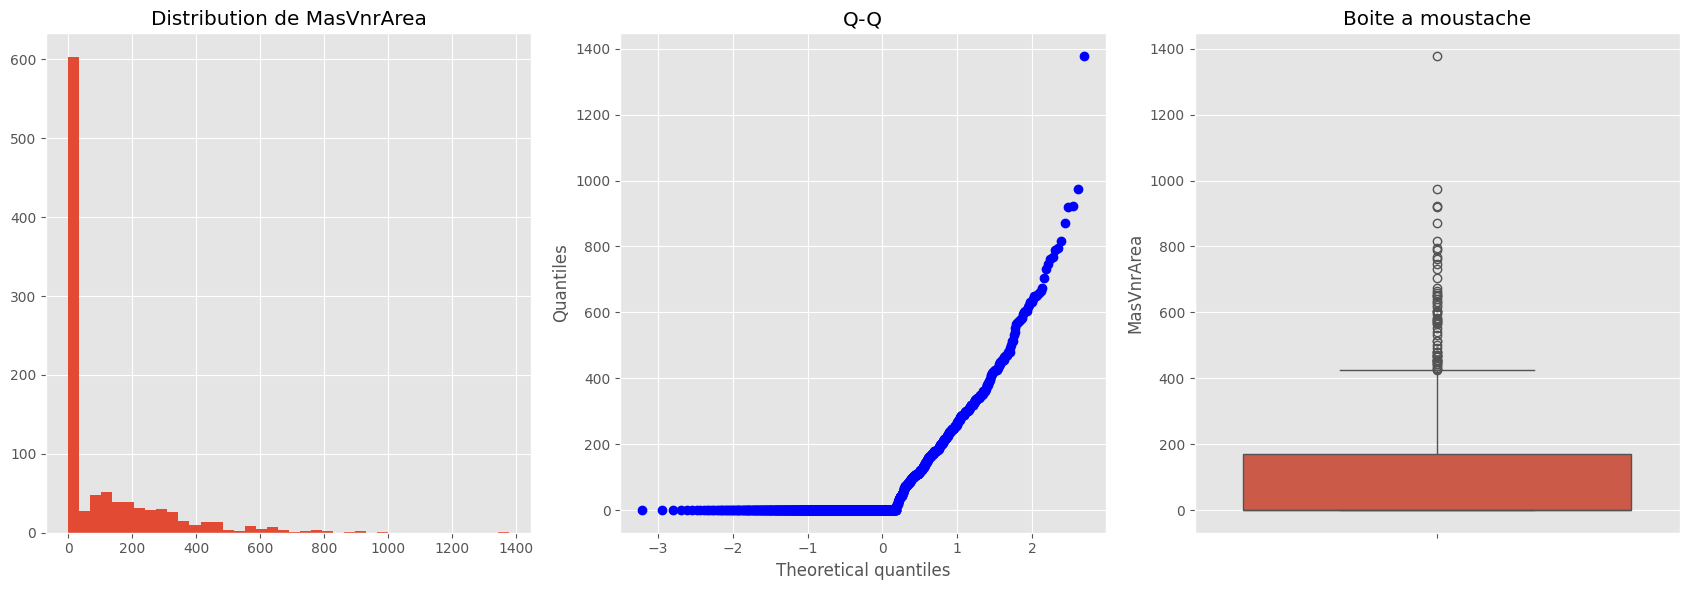

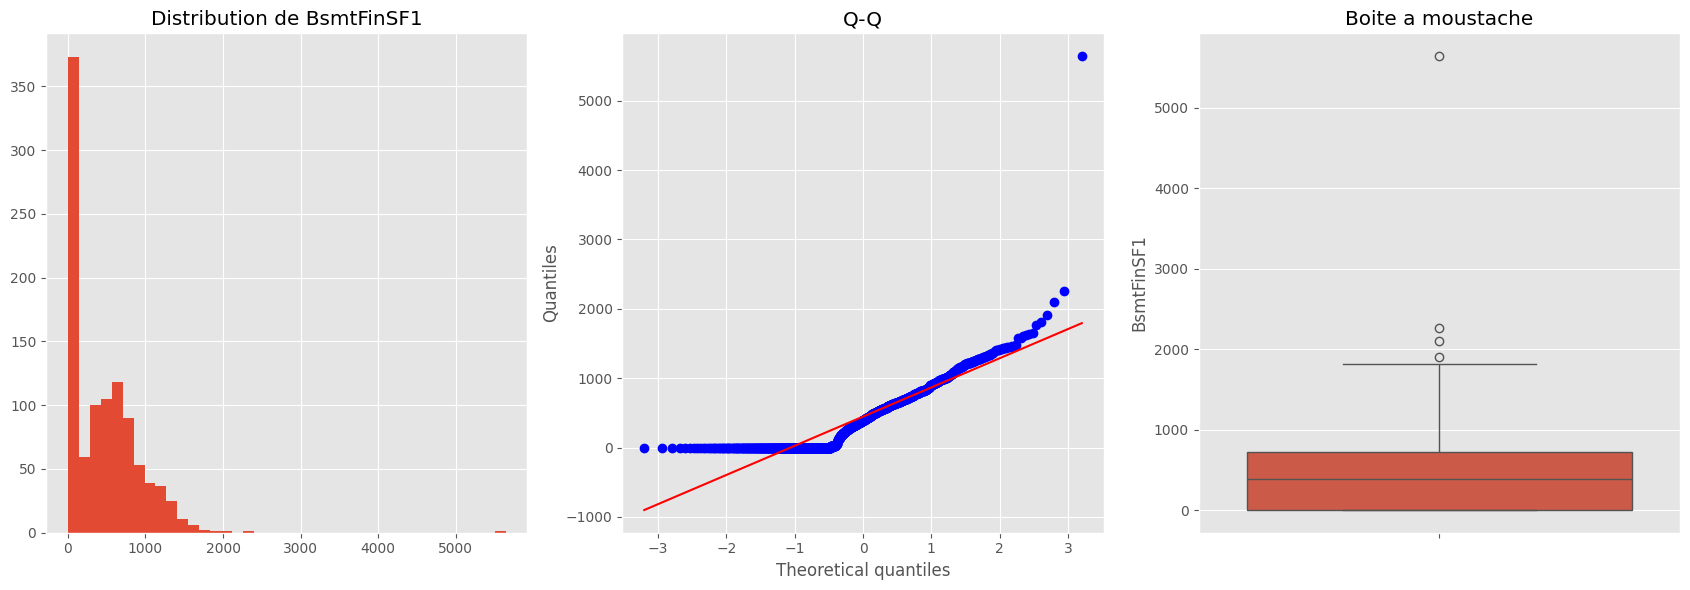

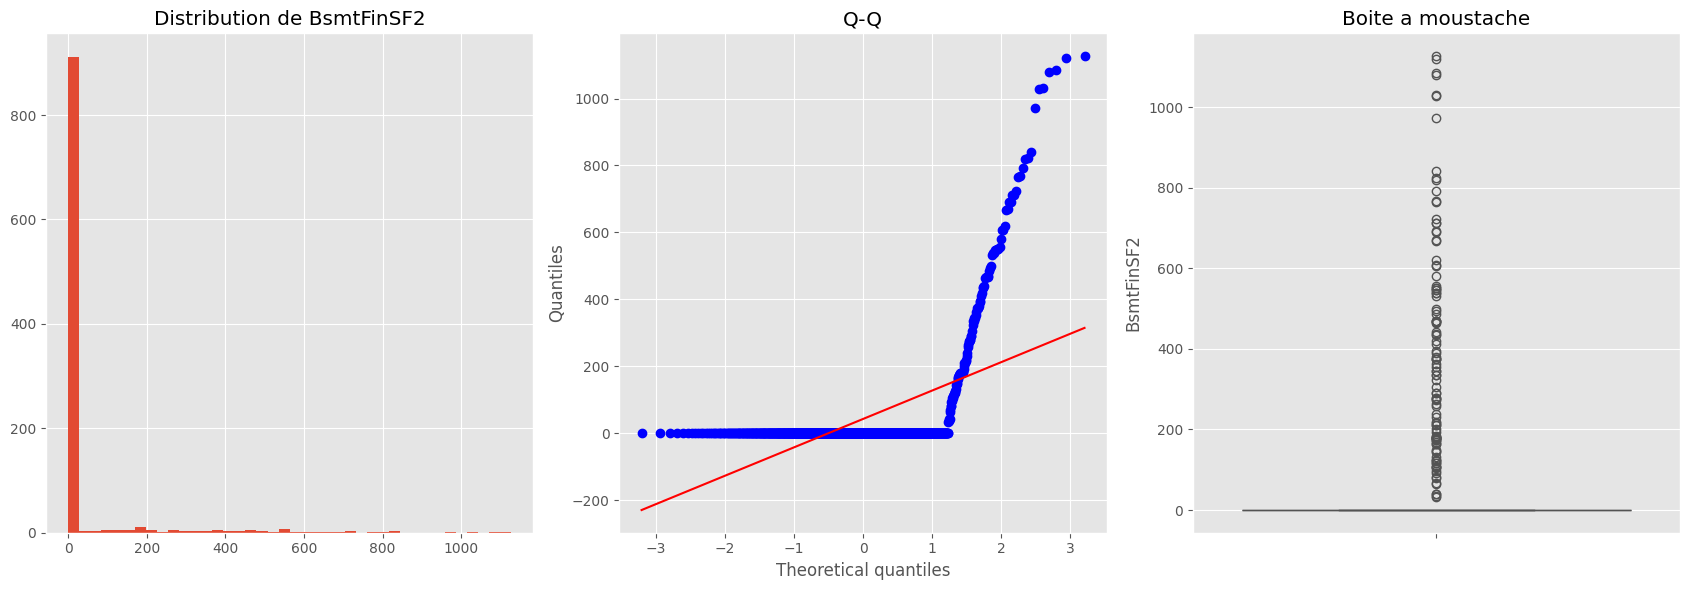

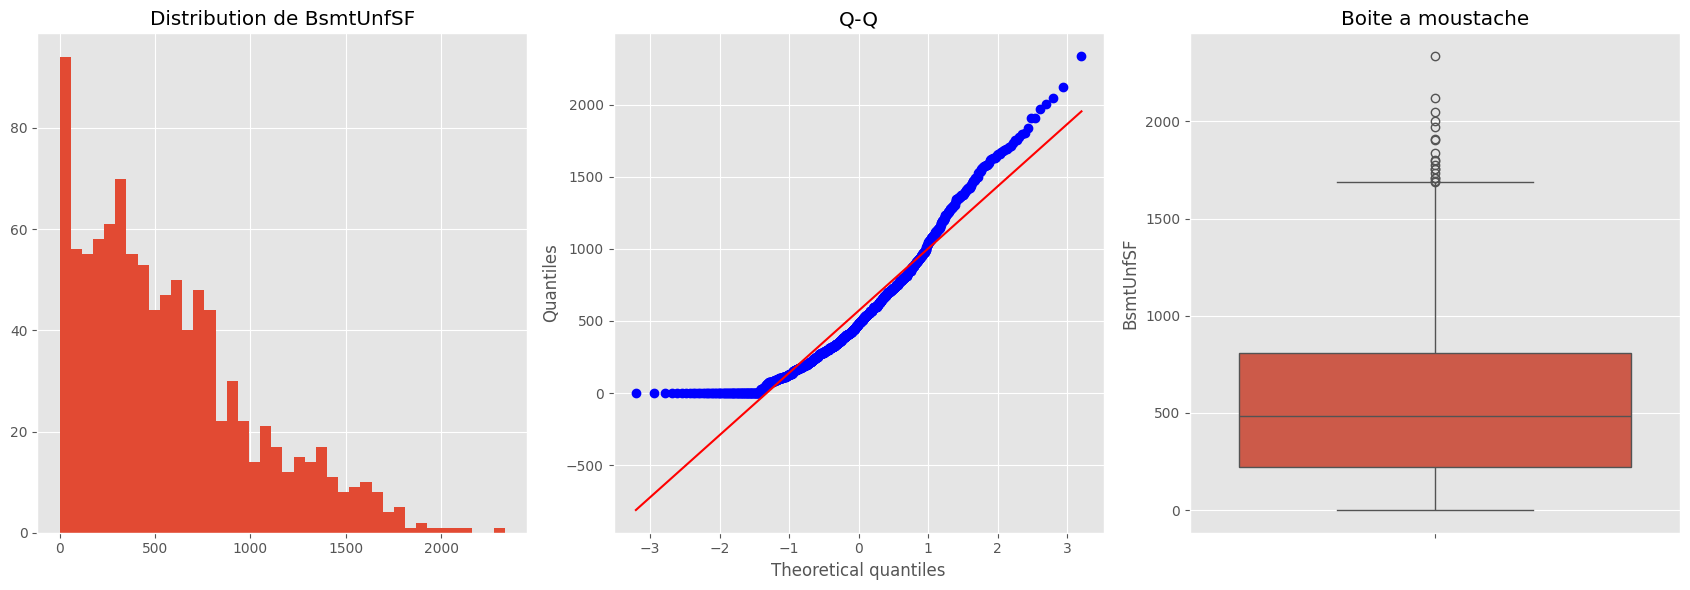

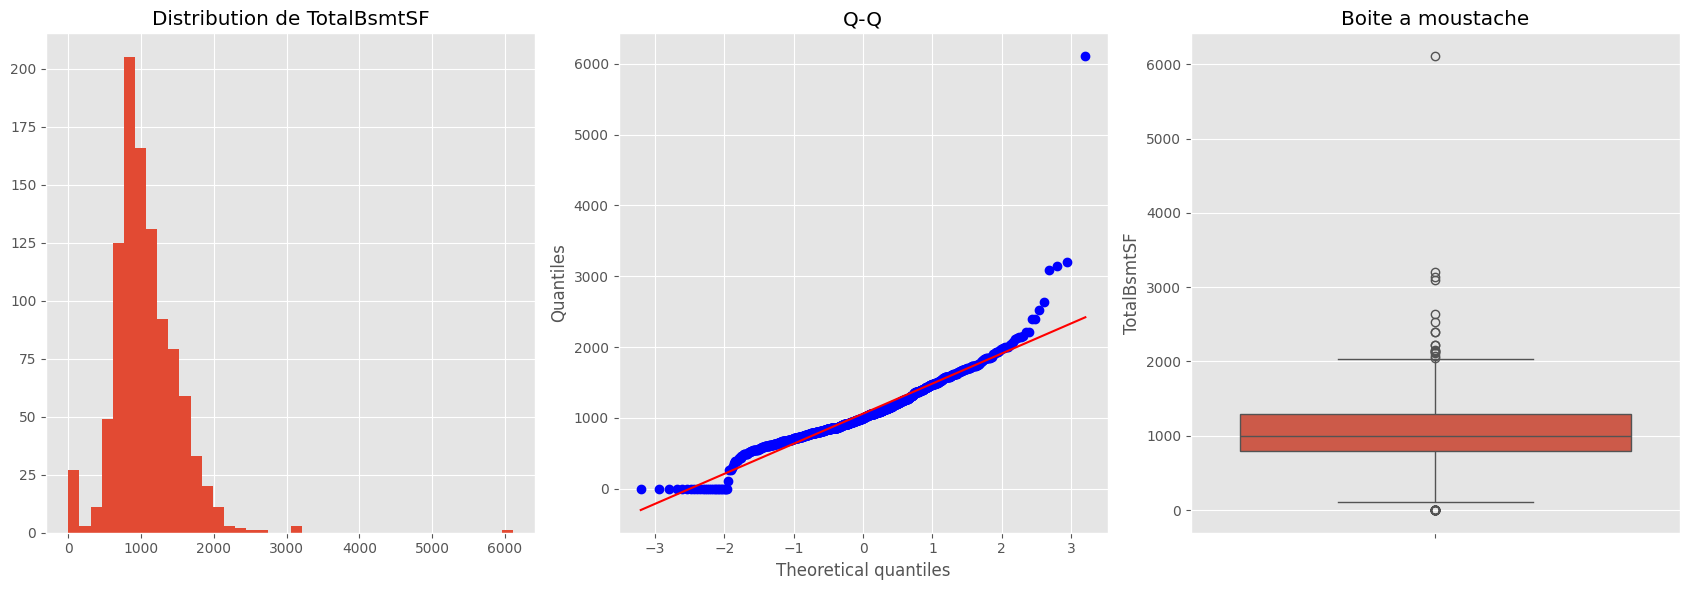

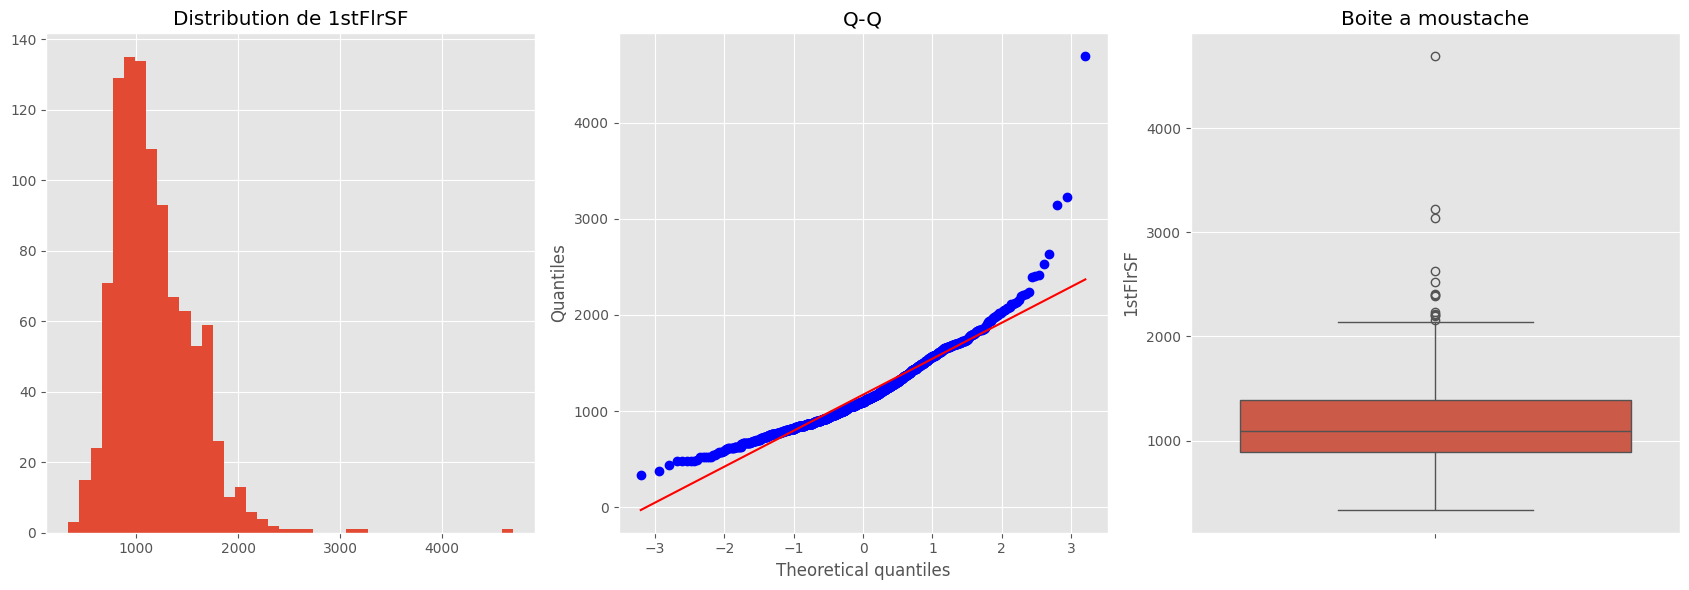

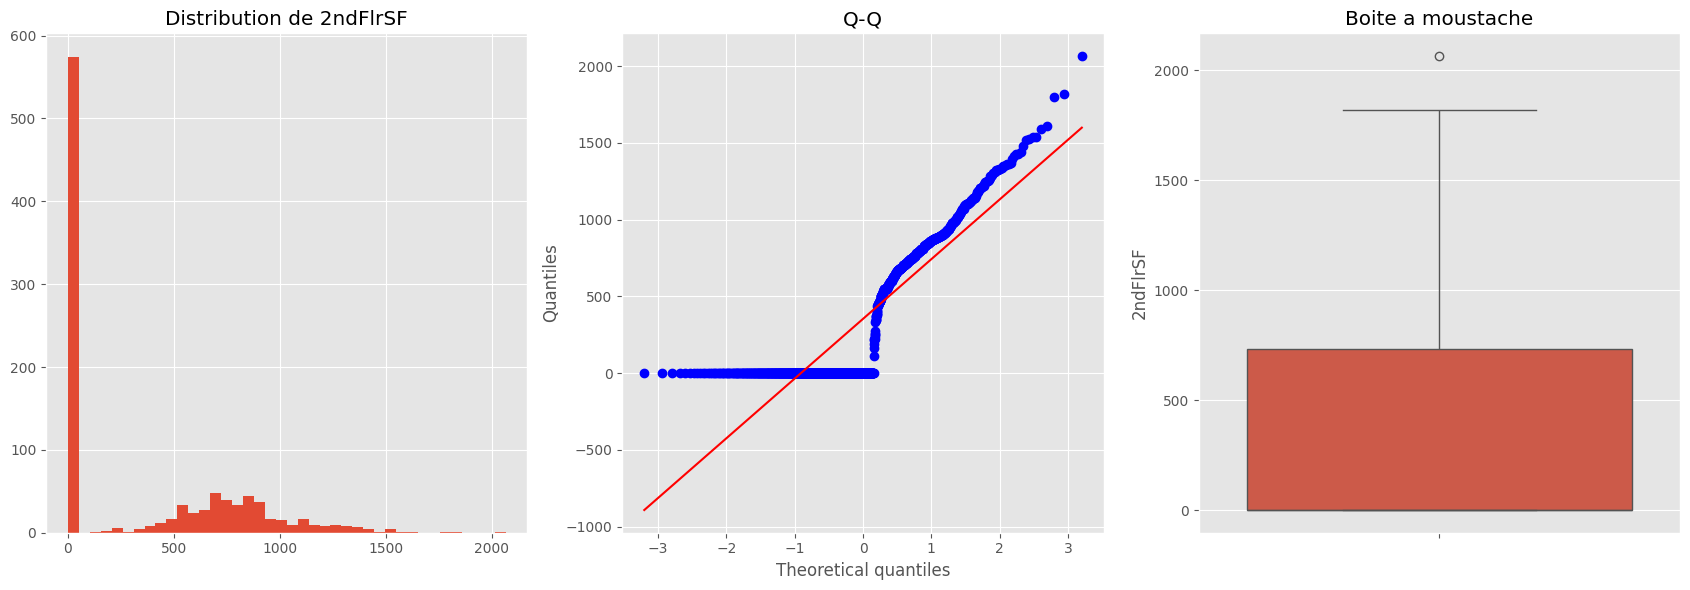

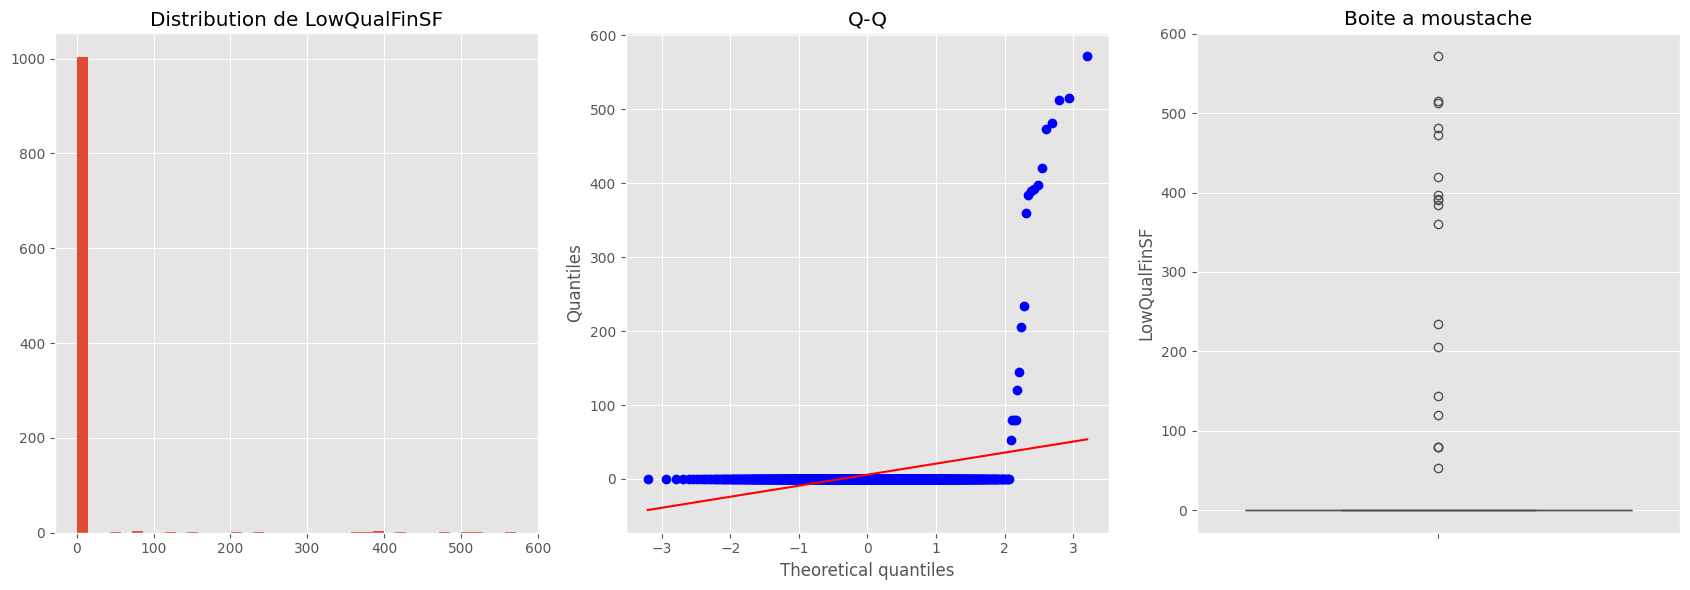

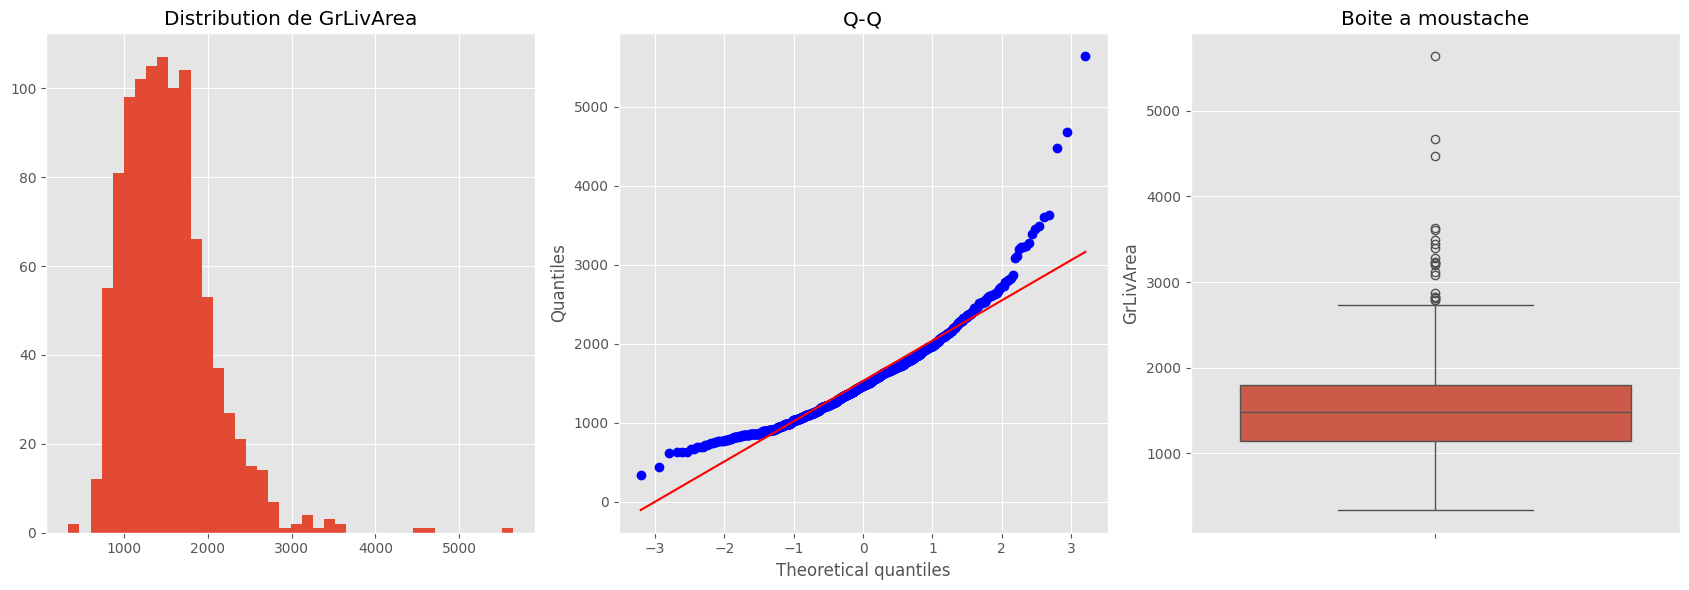

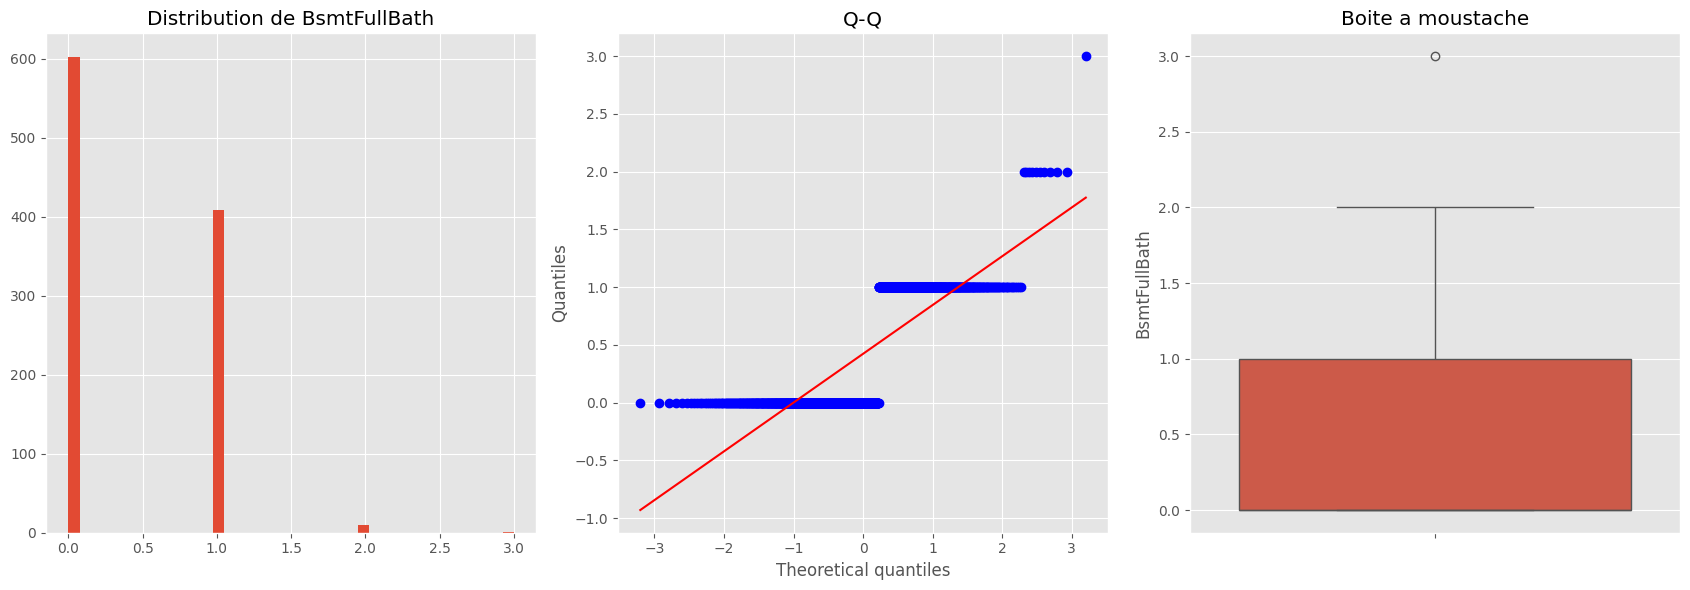

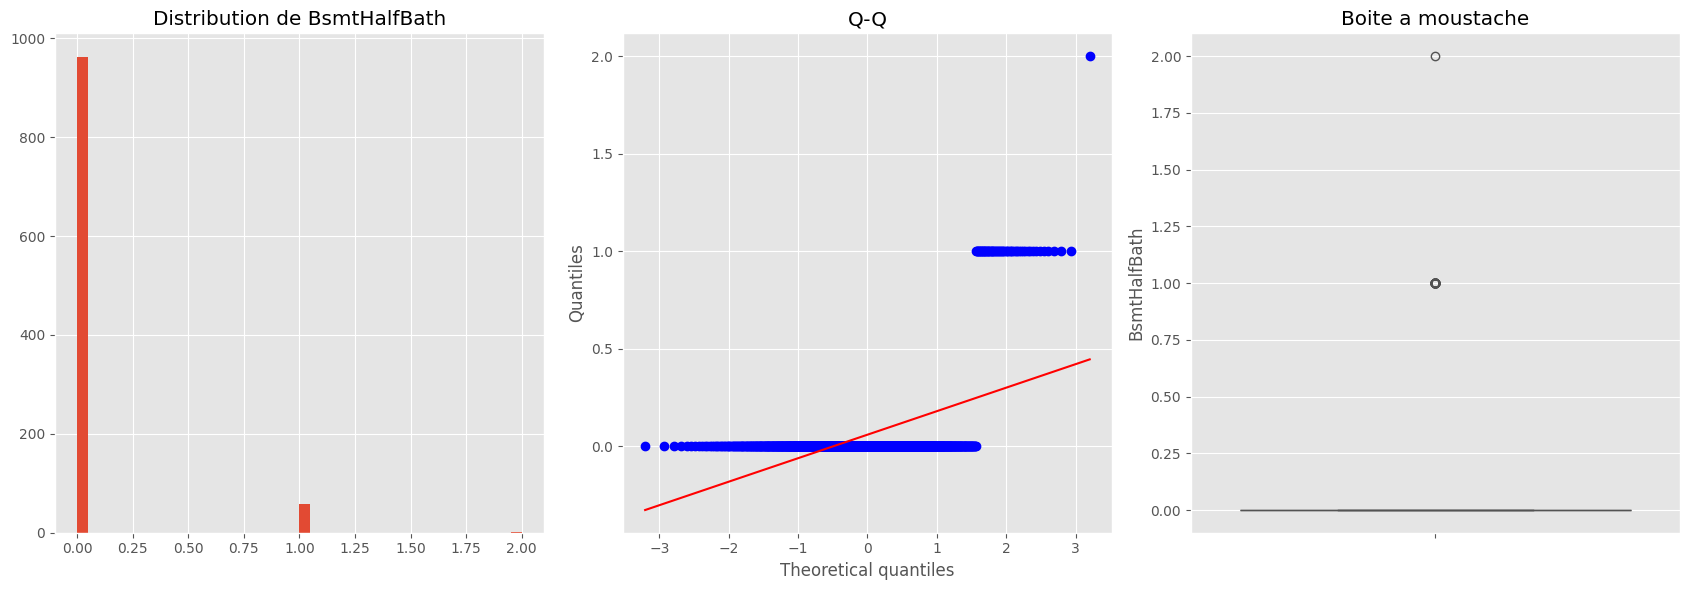

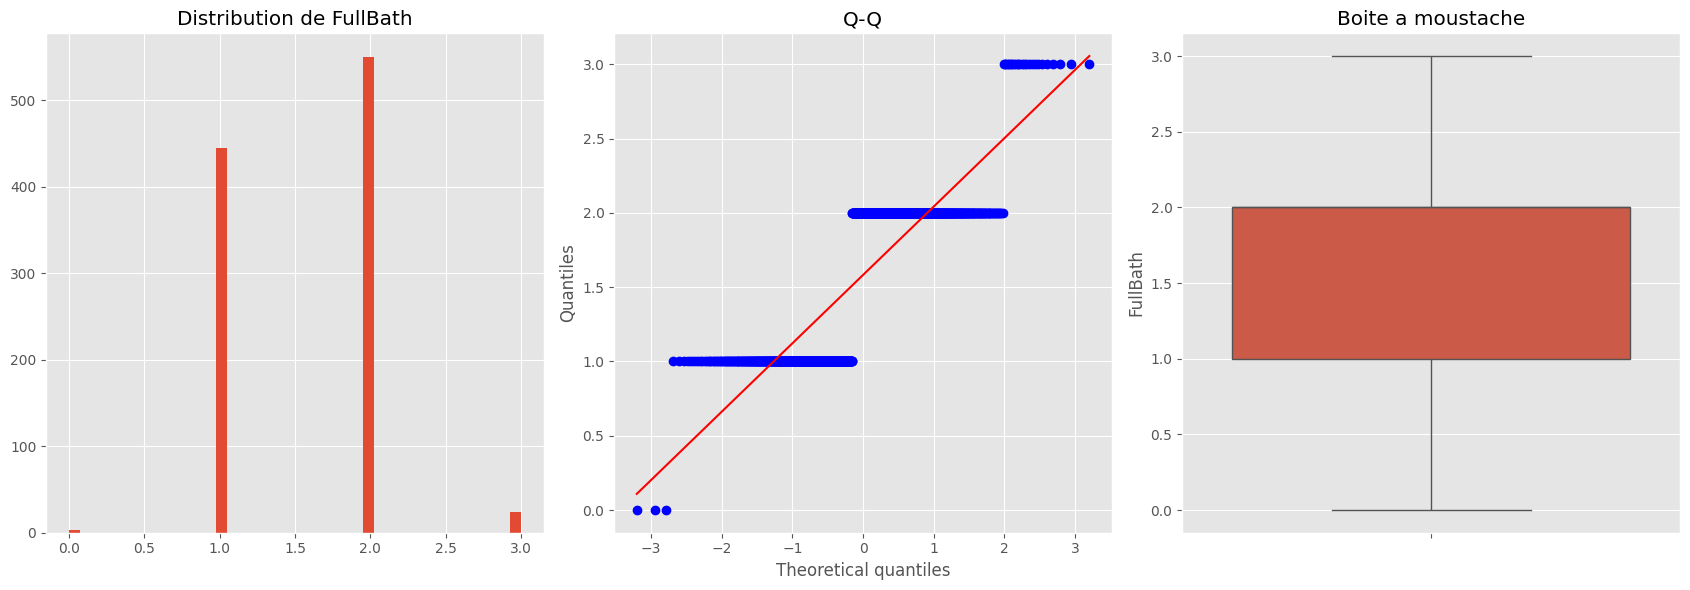

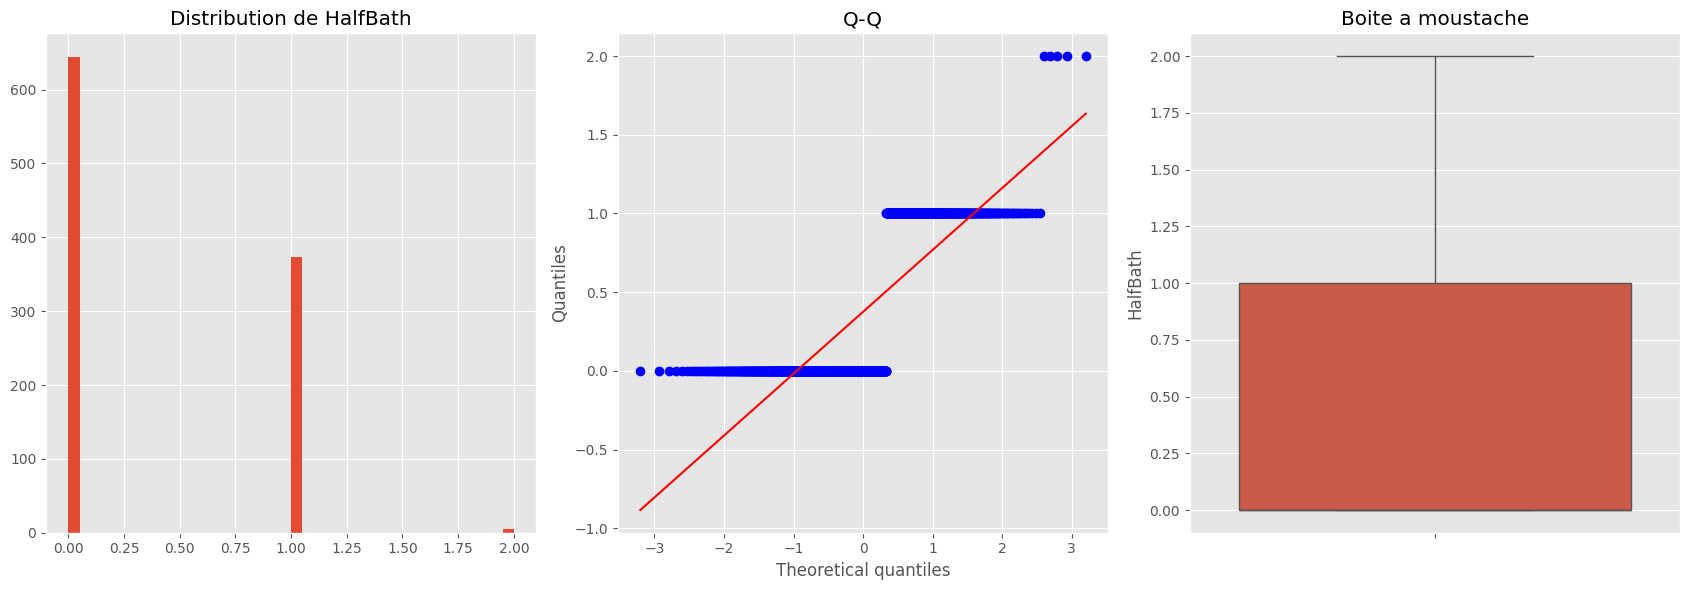

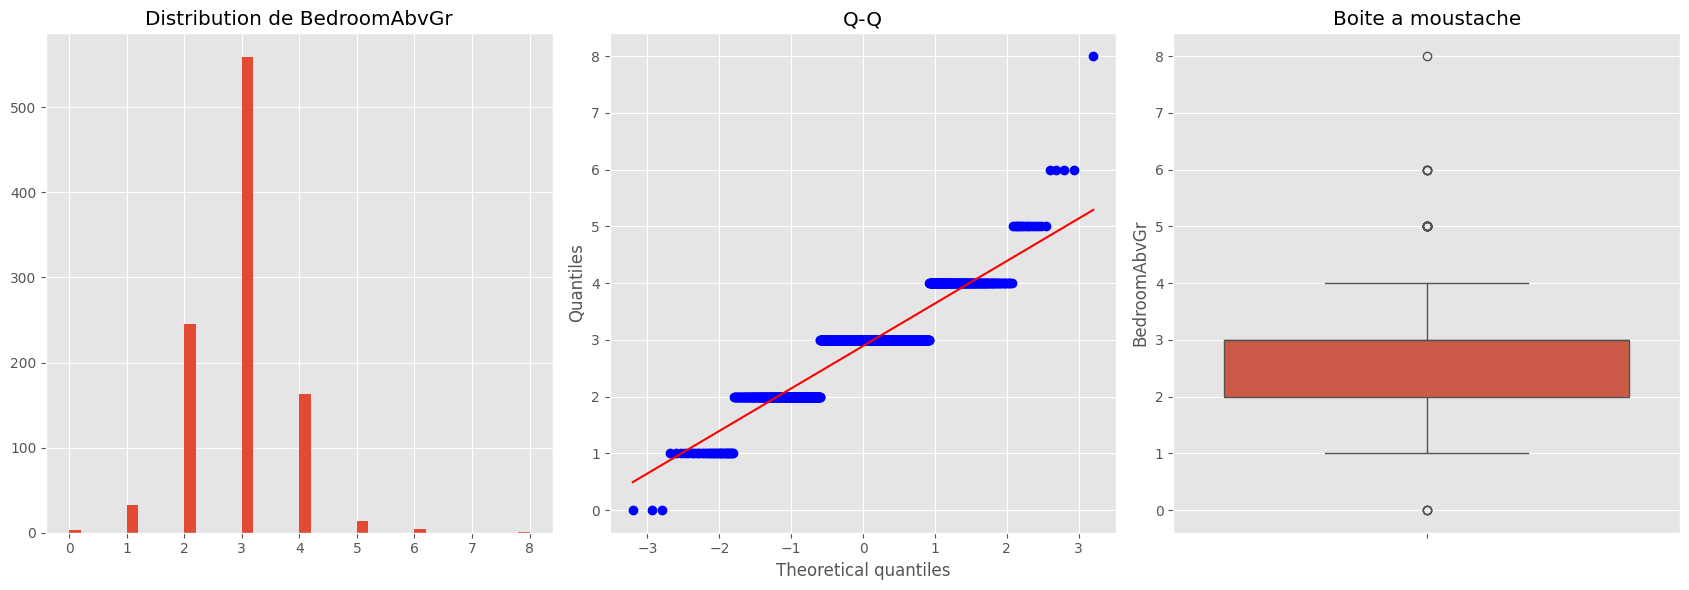

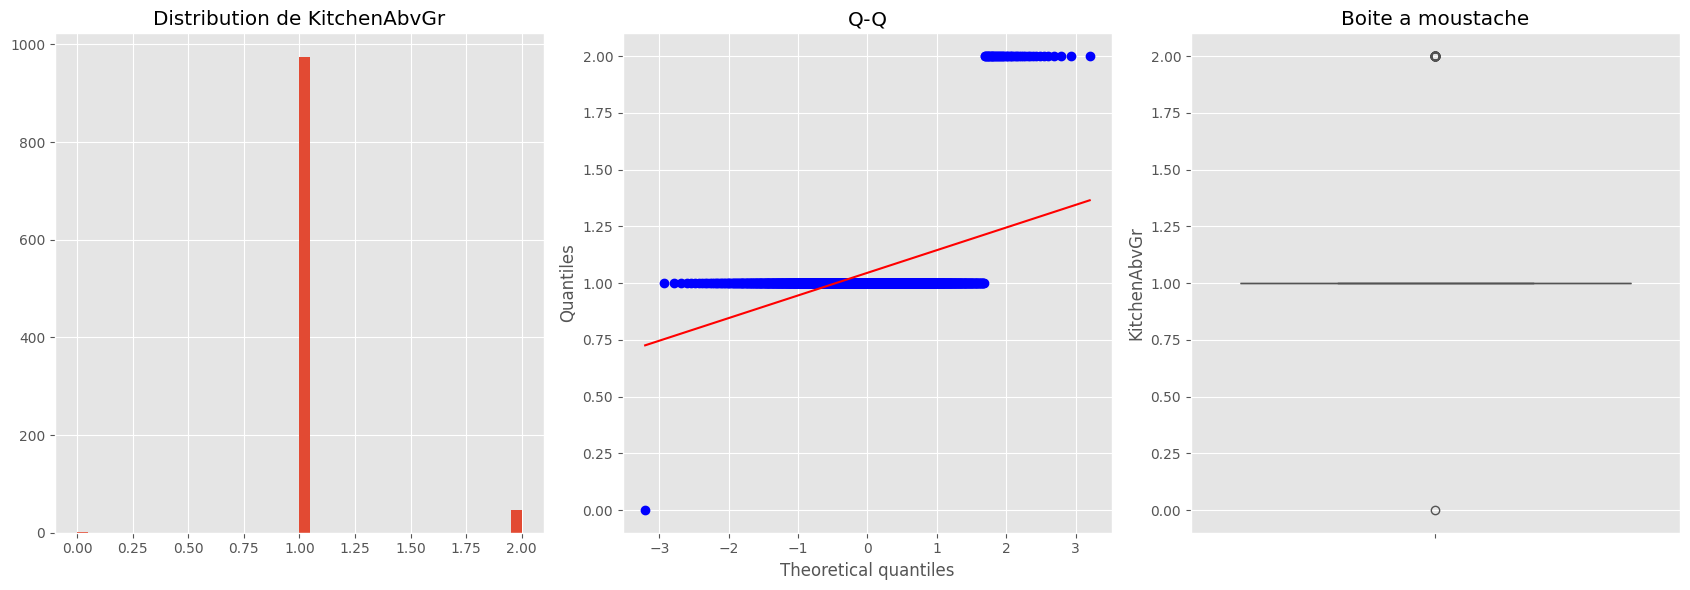

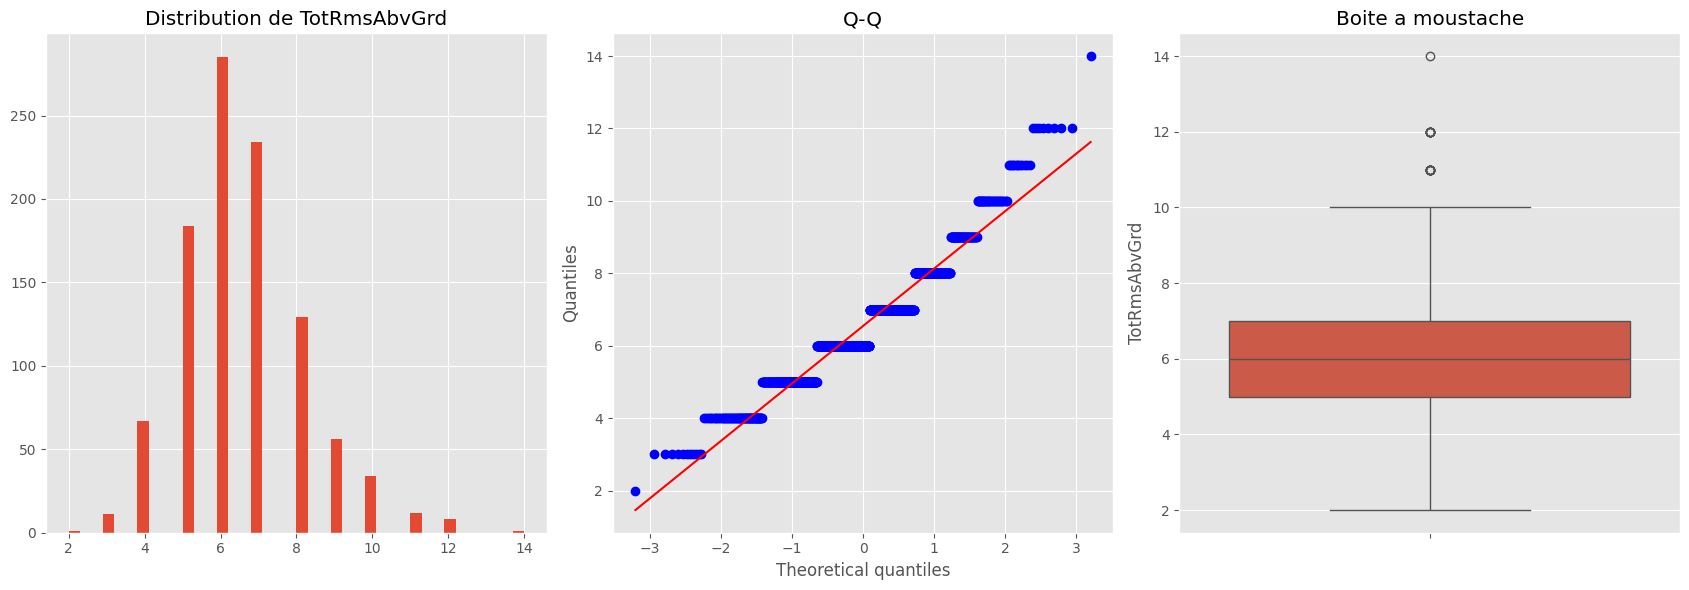

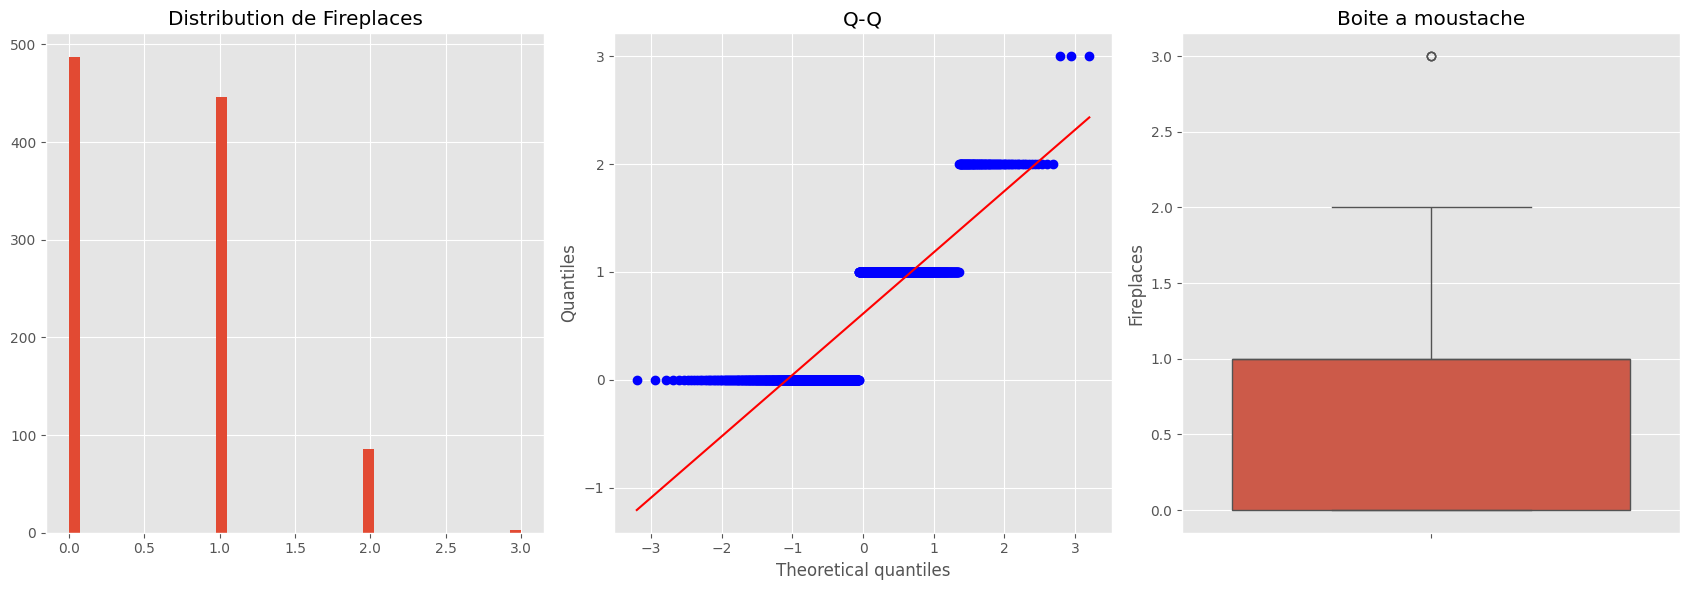

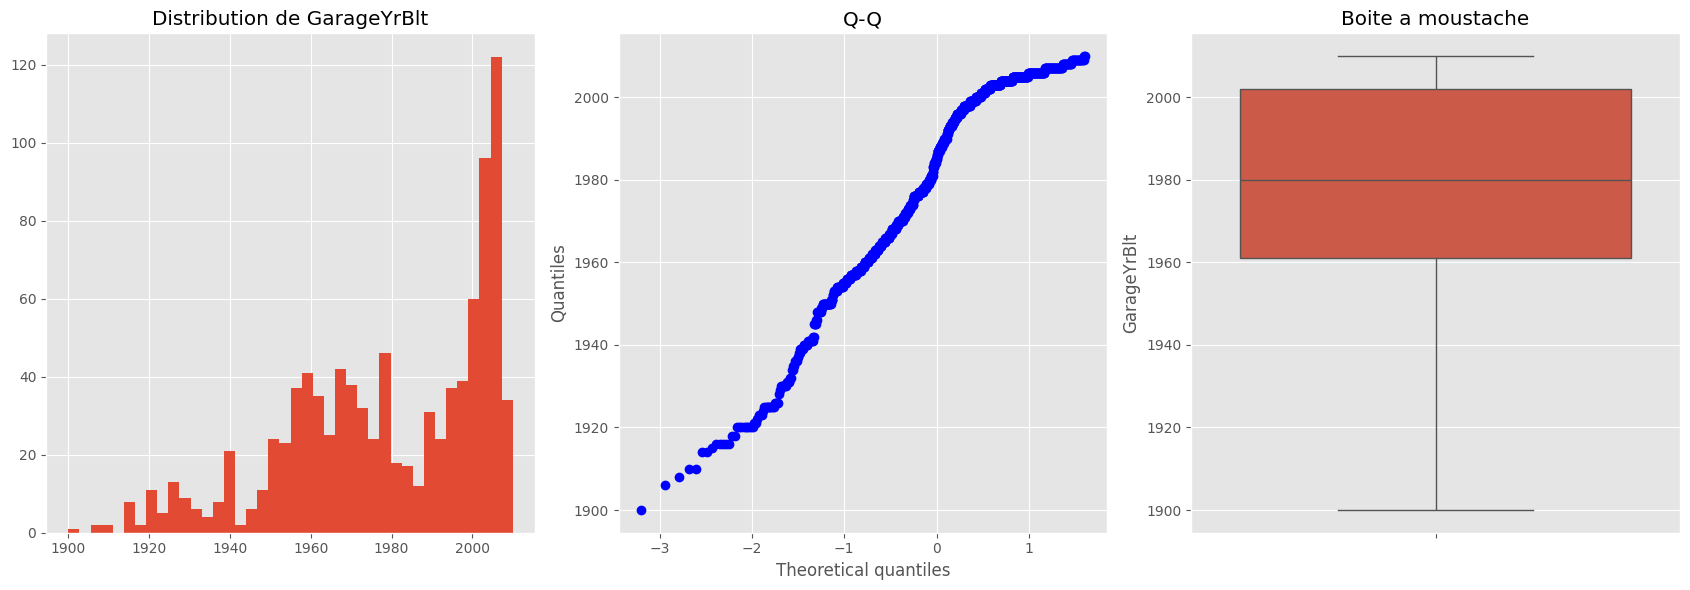

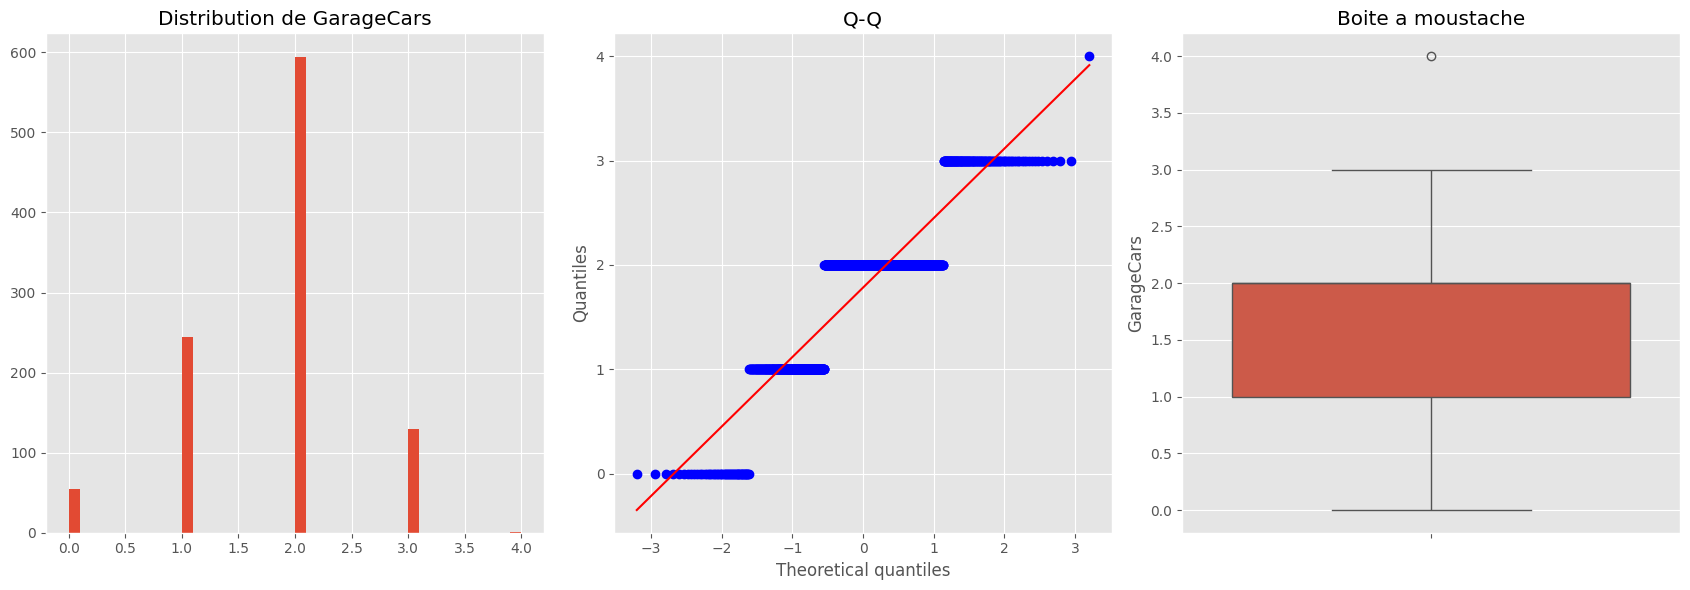

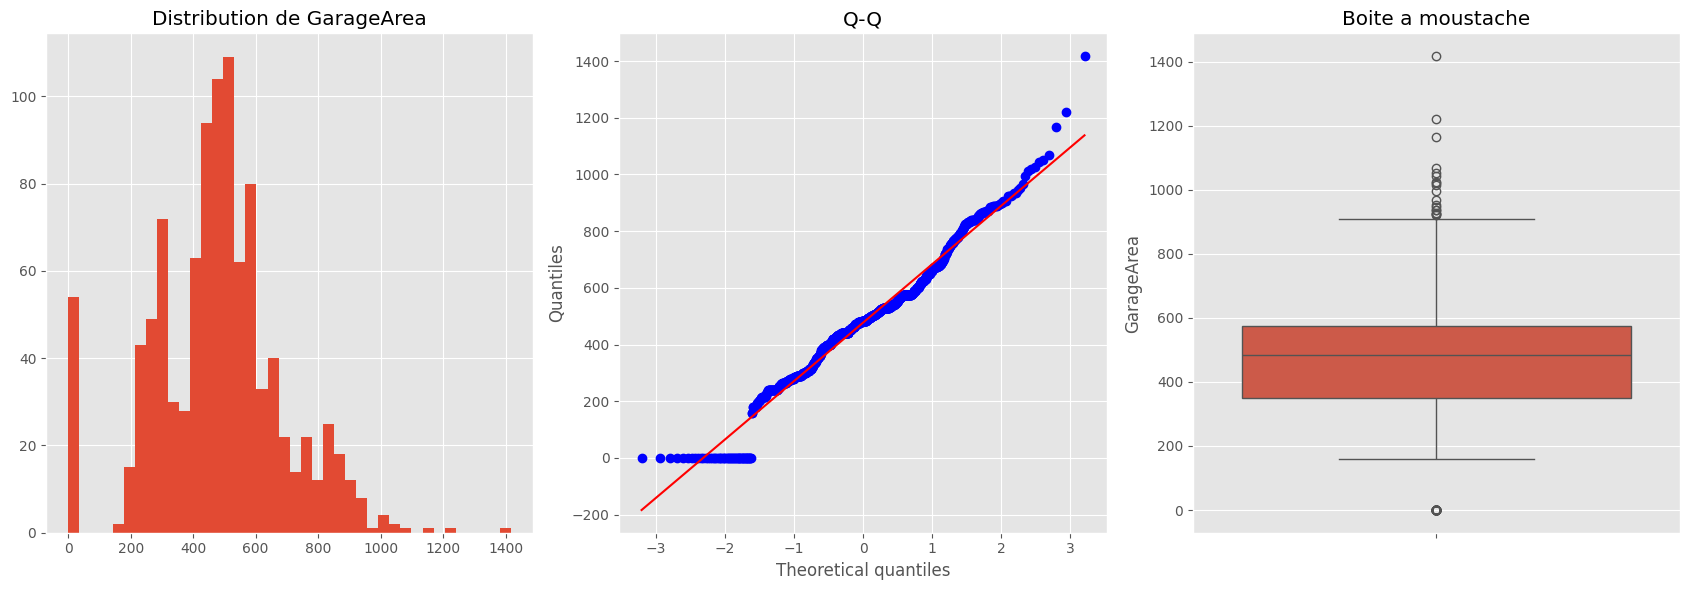

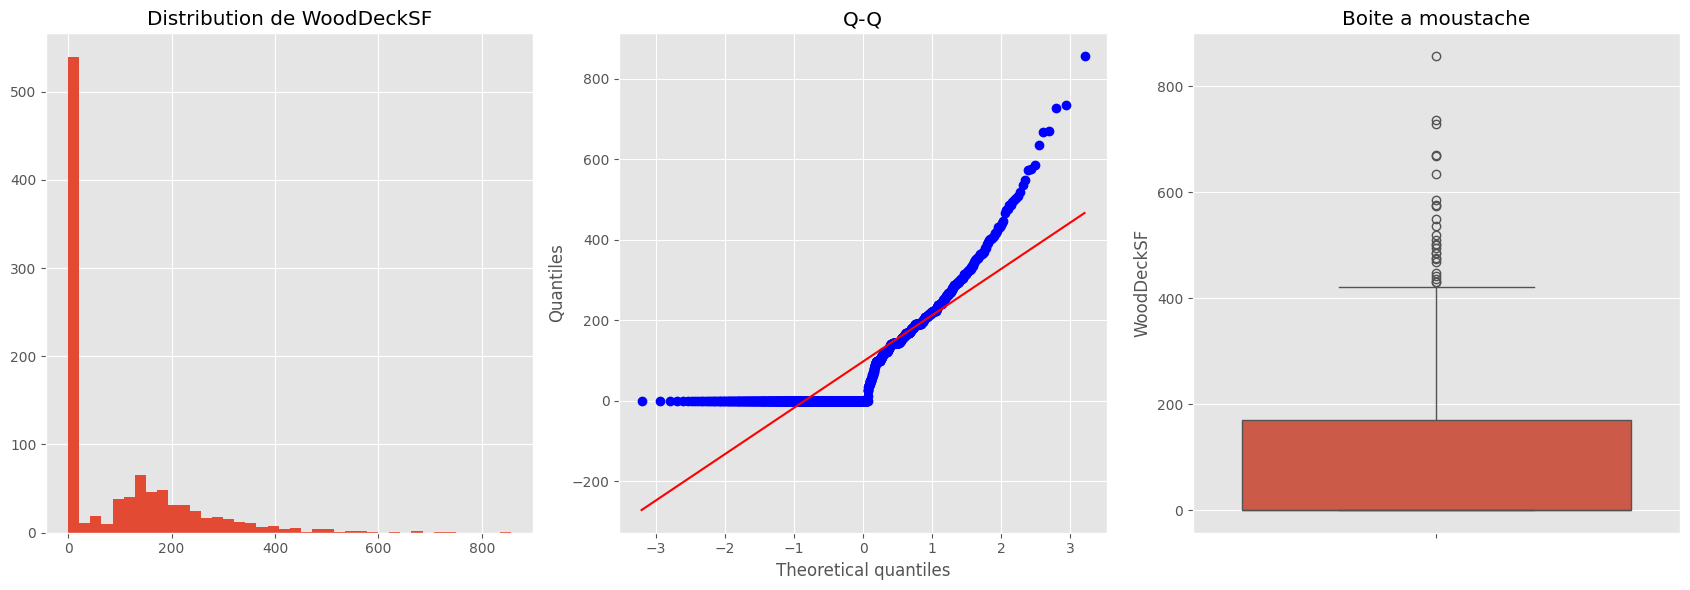

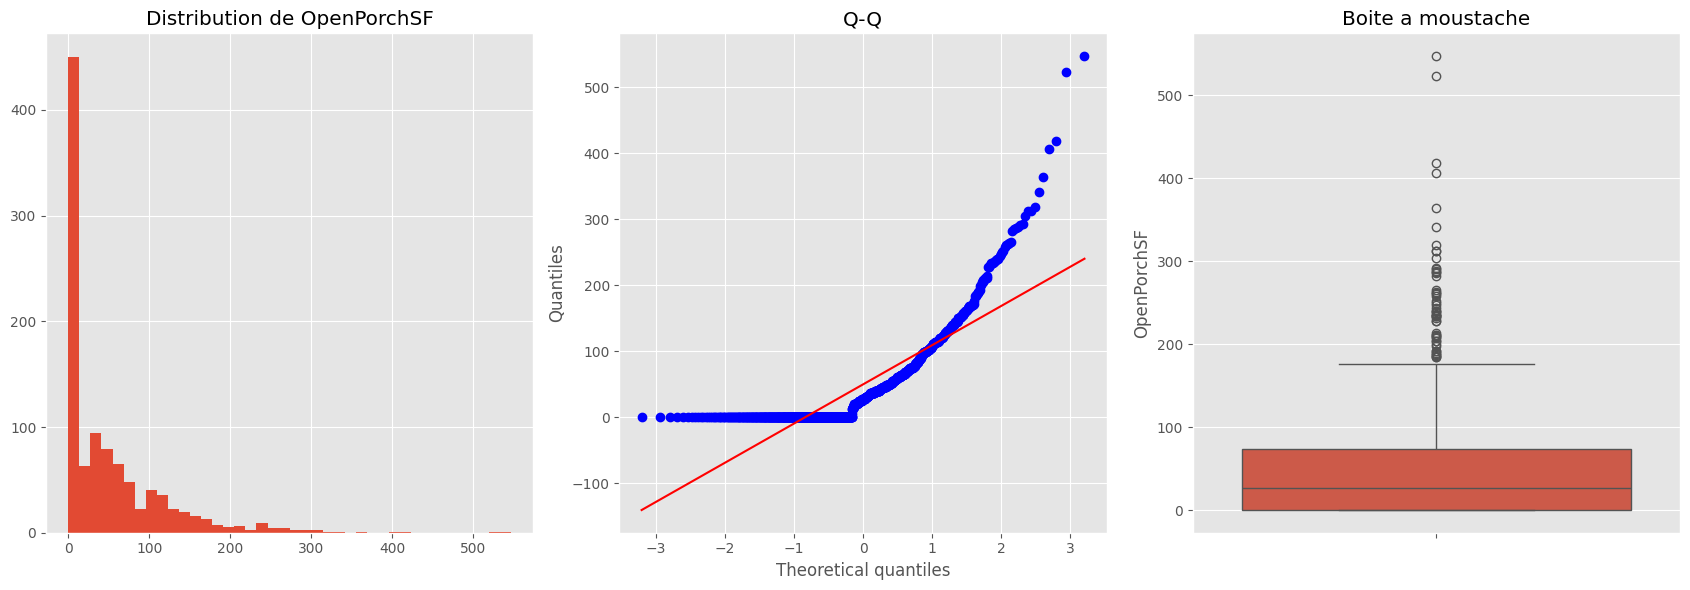

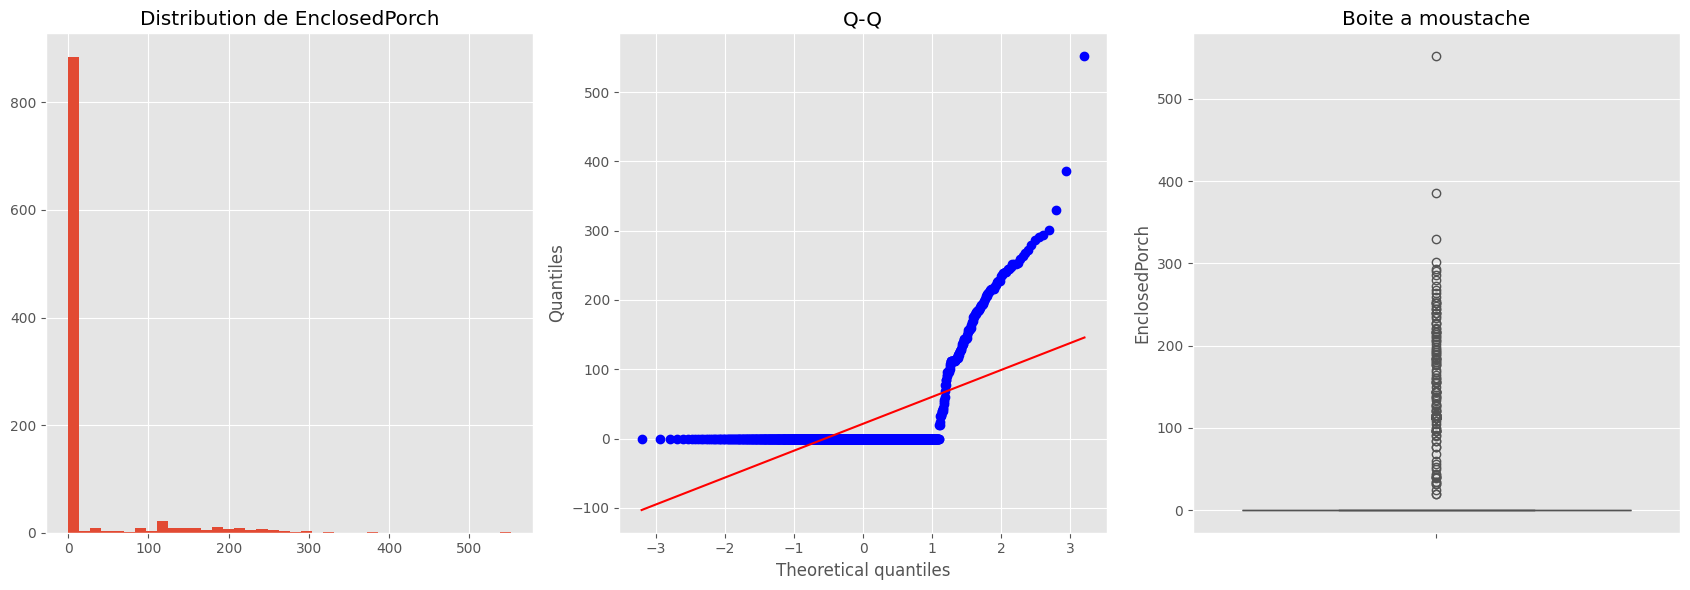

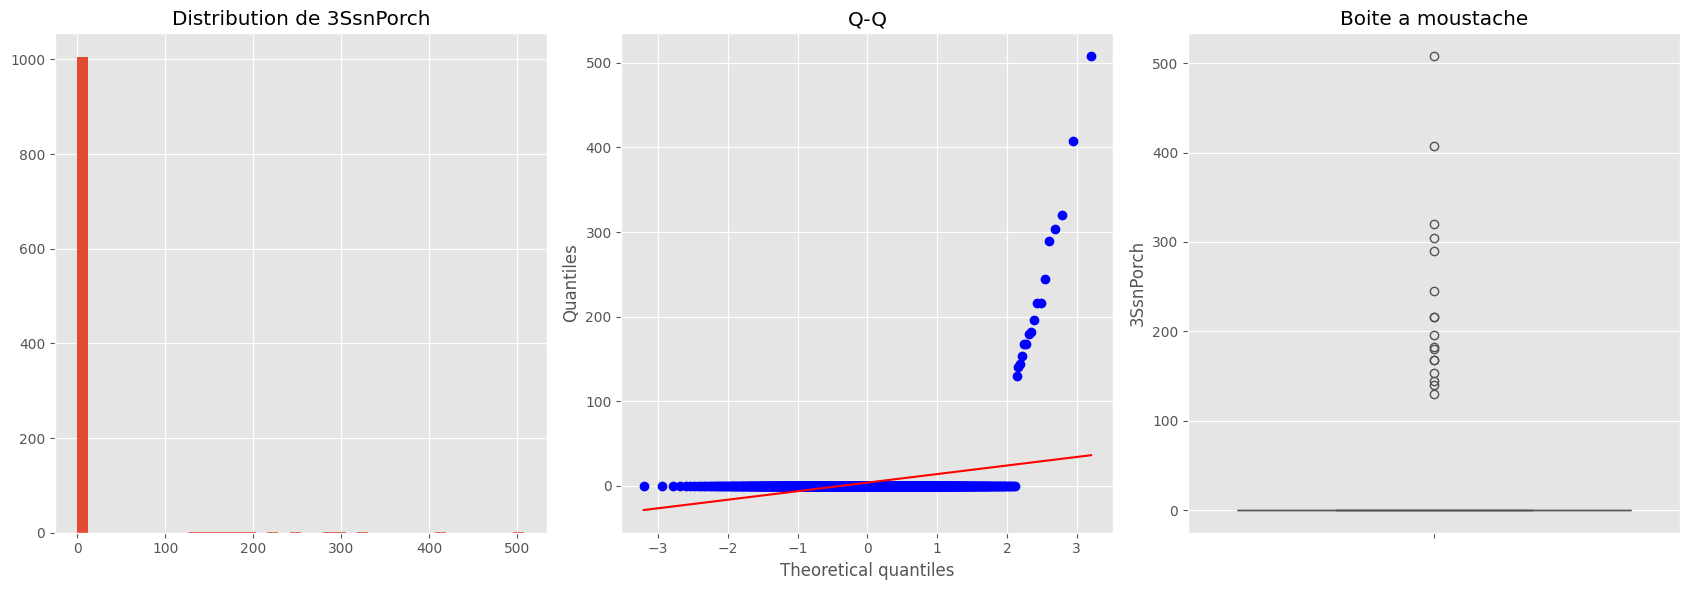

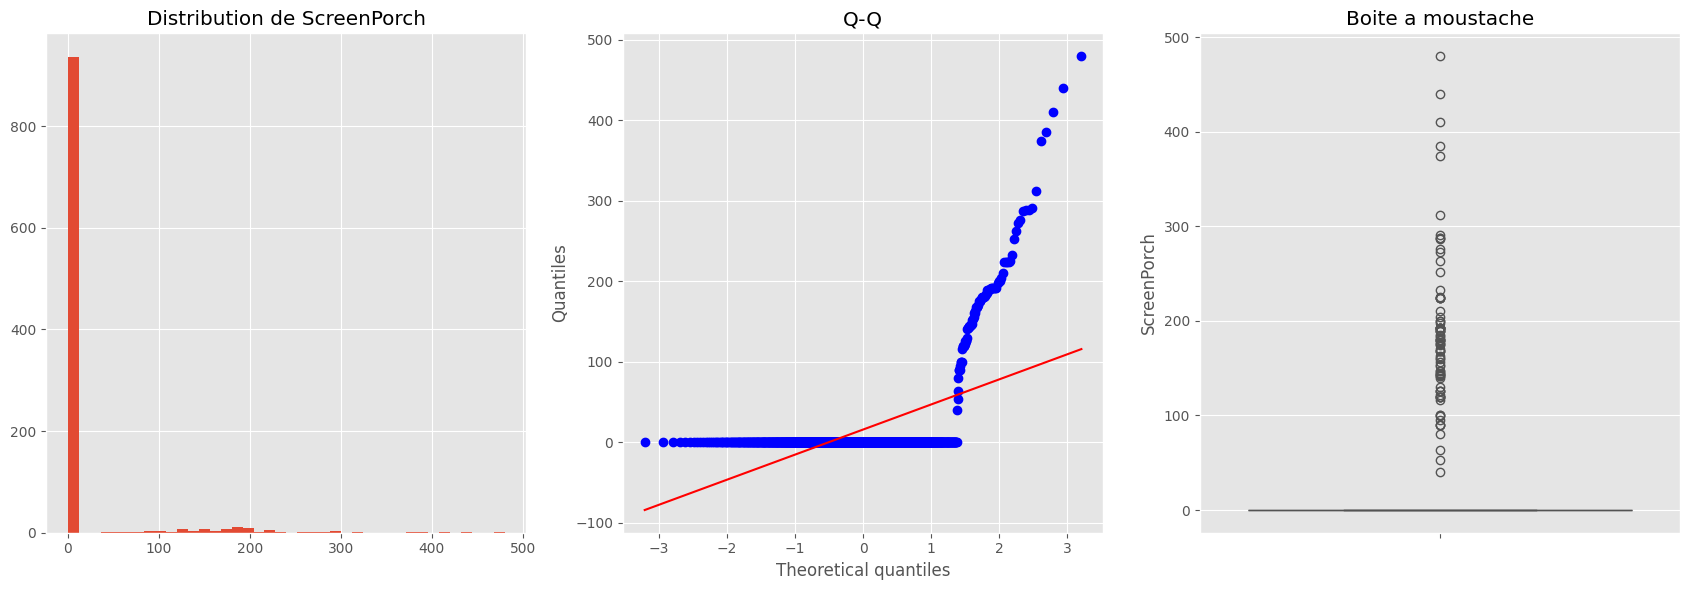

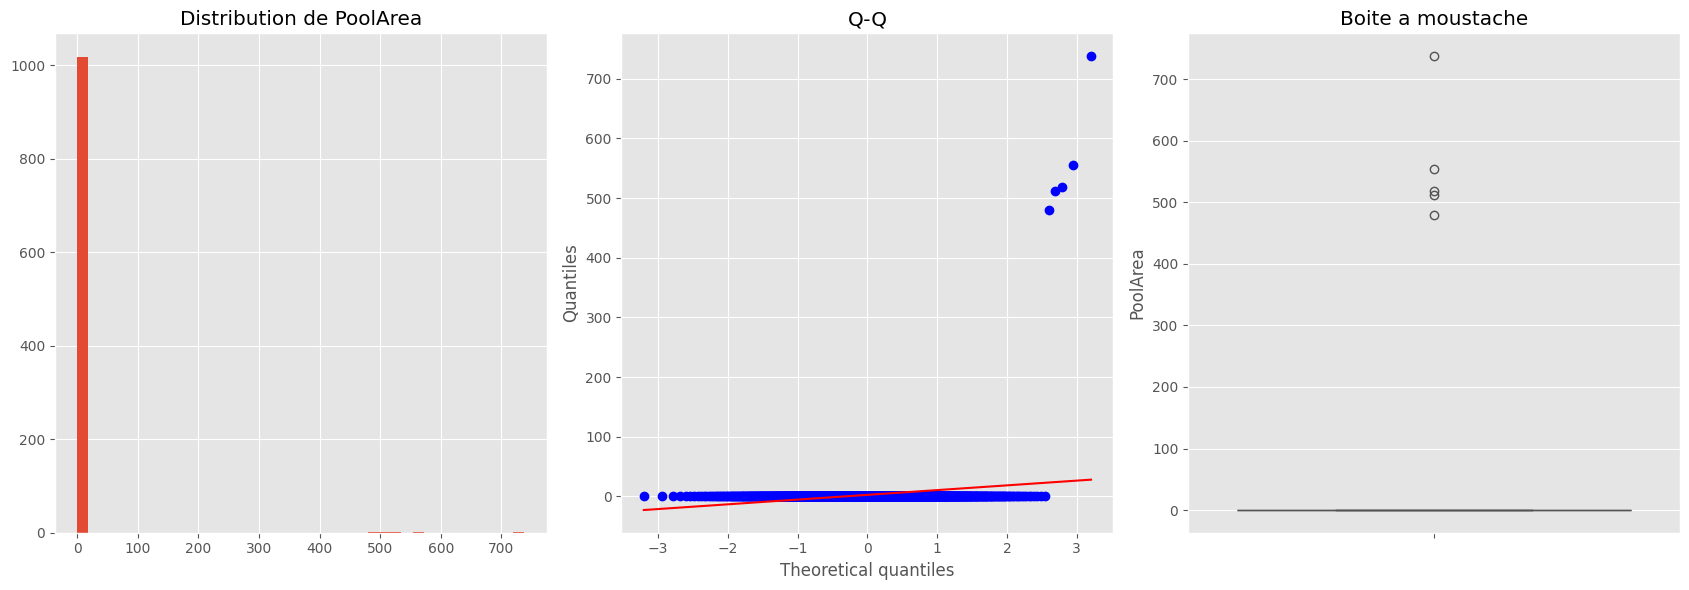

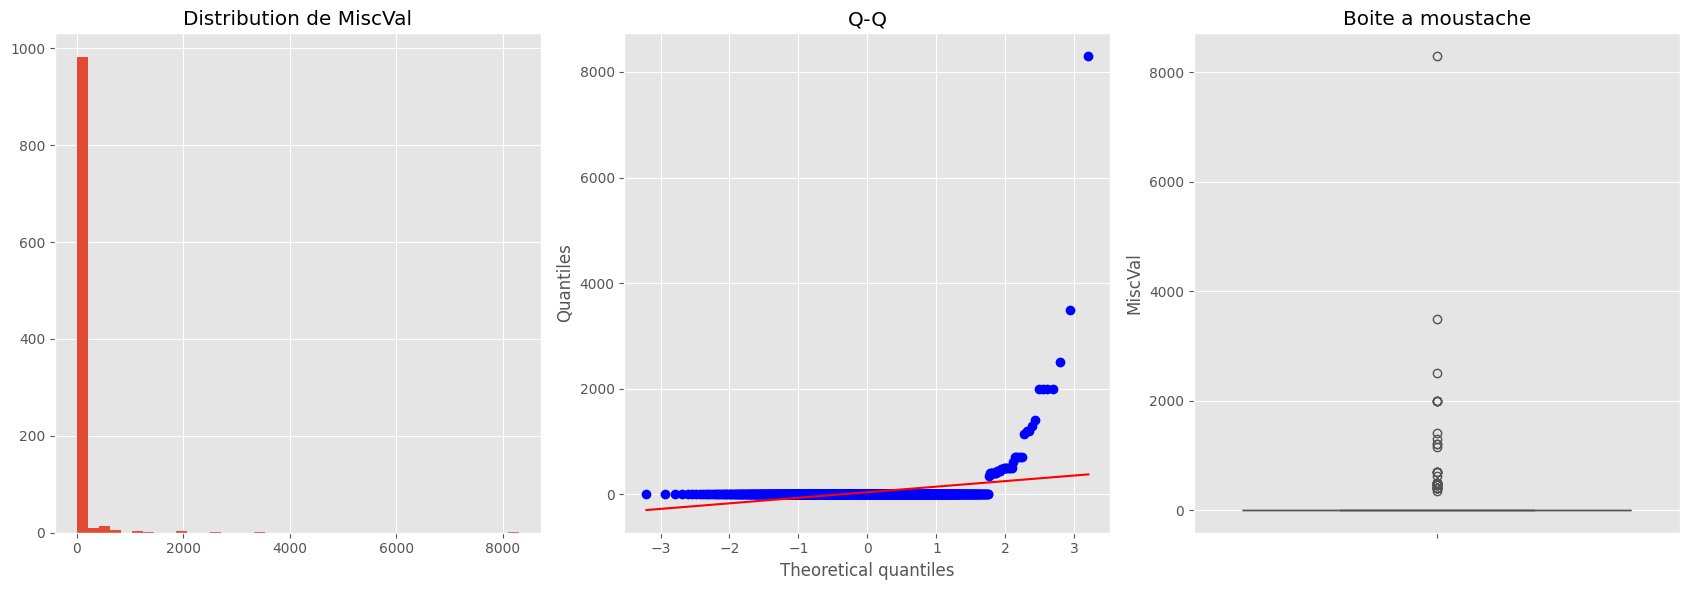

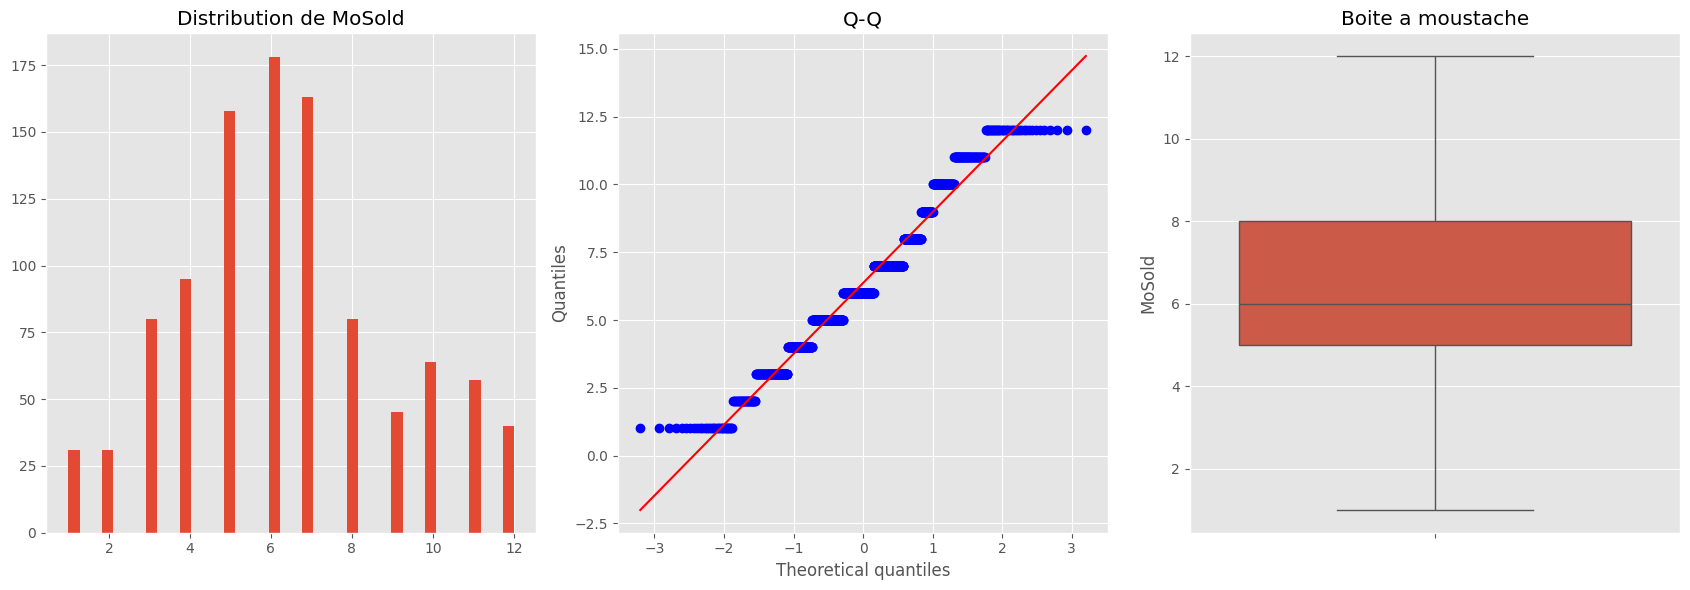

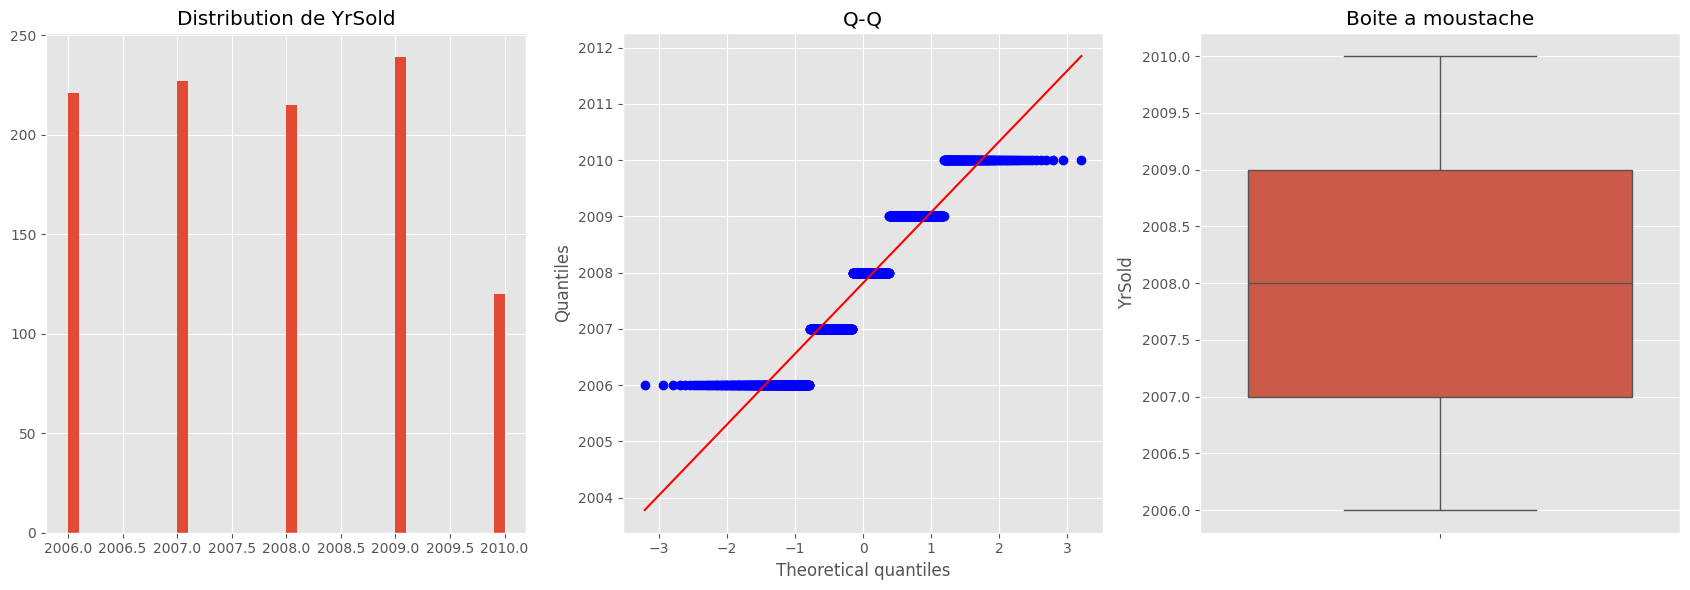

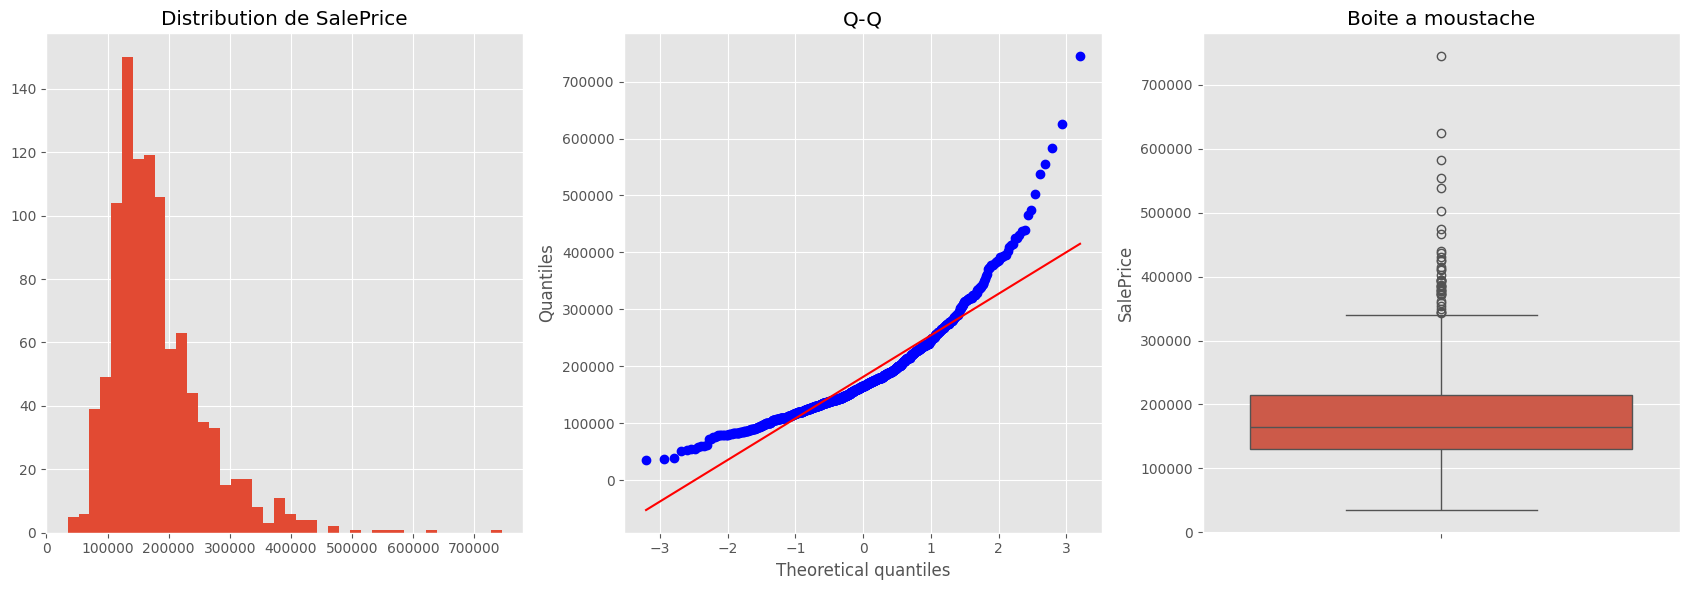

In [5]:
# Pour l'instant, nous analyserons seulement les donnees numeriques
# et nous tenterons de dresser les premiers diagnostiques pour trouver
# les parametres qui ont de la valeur
numeric_vars = train.select_dtypes(include=["number"])

def diagnostic_plots(df, variable):
    """
    Cette fonction trace un histogramme, un diagrame Q-Q, et une boite a moustache d'une variable.
    :param df: DataFrame contenant la donnee
    :param variable: variable a afficher
    """

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 6))
    
    # histogramme
    axes[0].hist(df[variable], bins=40)
    axes[0].set_title("Distribution de {}".format(variable))
    
    # Q-Q
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    axes[1].set_ylabel("Quantiles")
    axes[1].set_title("Q-Q")
    
    # boite a moustache
    sns.boxplot(y=df[variable], ax=axes[2])
    axes[2].set_title("Boite a moustache")
    
    # Affichage
    plt.tight_layout()
    plt.show()
    
for v in numeric_vars:
    diagnostic_plots(train, v)  


OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  TotalBsmtSF  \
OverallQual      1.000000   0.555663      0.545434    0.426216     0.535962   
YearBuilt        0.555663   1.000000      0.595691    0.325085     0.394109   
YearRemodAdd     0.545434   0.595691      1.000000    0.172188     0.294756   
MasVnrArea       0.426216   0.325085      0.172188    1.000000     0.377162   
TotalBsmtSF      0.535962   0.394109      0.294756    0.377162     1.000000   
1stFlrSF         0.473924   0.269281      0.241672    0.348880     0.826623   
GrLivArea        0.583895   0.162547      0.282890    0.377607     0.454879   
FullBath         0.532273   0.461168      0.450088    0.277548     0.306800   
TotRmsAbvGrd     0.423463   0.062265      0.177460    0.270790     0.279516   
Fireplaces       0.395803   0.116650      0.101577    0.250641     0.335230   
GarageYrBlt      0.513386   0.816767      0.647678    0.253010     0.317474   
GarageCars       0.591608   0.513213      0.420649    0.359553     0.437701   
GarageArea       0.554317   0.459184      0.367286    0.385493     0.490806   
SalePrice        0.784720   0.512206      0.512190    0.454514     0.590017   

              1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  Fireplaces  \
OverallQual   0.473924   0.583895  0.532273      0.423463    0.395803   
YearBuilt     0.269281   0.162547  0.461168      0.062265    0.116650   
YearRemodAdd  0.241672   0.282890  0.450088      0.177460    0.101577   
MasVnrArea    0.348880   0.377607  0.277548      0.270790    0.250641   
TotalBsmtSF   0.826623   0.454879  0.306800      0.279516    0.335230   
1stFlrSF      1.000000   0.562794  0.363879      0.401990    0.405244   
GrLivArea     0.562794   1.000000  0.616459      0.822992    0.459041   
FullBath      0.363879   0.616459  1.000000      0.548176    0.223852   
TotRmsAbvGrd  0.401990   0.822992  0.548176      1.000000    0.327097   
Fireplaces    0.405244   0.459041  0.223852      0.327097    1.000000   
GarageYrBlt   0.231008   0.204855  0.468612      0.115481    0.021959   
GarageCars    0.431472   0.464632  0.471876      0.348143    0.279266   
GarageArea    0.485543   0.482921  0.416145      0.337939    0.258872   
SalePrice     0.583132   0.689238  0.549164      0.519634    0.461329   

              GarageYrBlt  GarageCars  GarageArea  SalePrice  
OverallQual      0.513386    0.591608    0.554317   0.784720  
YearBuilt        0.816767    0.513213    0.459184   0.512206  
YearRemodAdd     0.647678    0.420649    0.367286   0.512190  
MasVnrArea       0.253010    0.359553    0.385493   0.454514  
TotalBsmtSF      0.317474    0.437701    0.490806   0.590017  
1stFlrSF         0.231008    0.431472    0.485543   0.583132  
GrLivArea        0.204855    0.464632    0.482921   0.689238  
FullBath         0.468612    0.471876    0.416145   0.549164  
TotRmsAbvGrd     0.115481    0.348143    0.337939   0.519634  
Fireplaces       0.021959    0.279266    0.258872   0.461329  
GarageYrBlt      1.000000    0.573399    0.551119   0.474363  
GarageCars       0.573399    1.000000    0.881004   0.642689  
GarageArea       0.551119    0.881004    1.000000   0.621937  
SalePrice        0.474363    0.642689    0.621937   1.000000

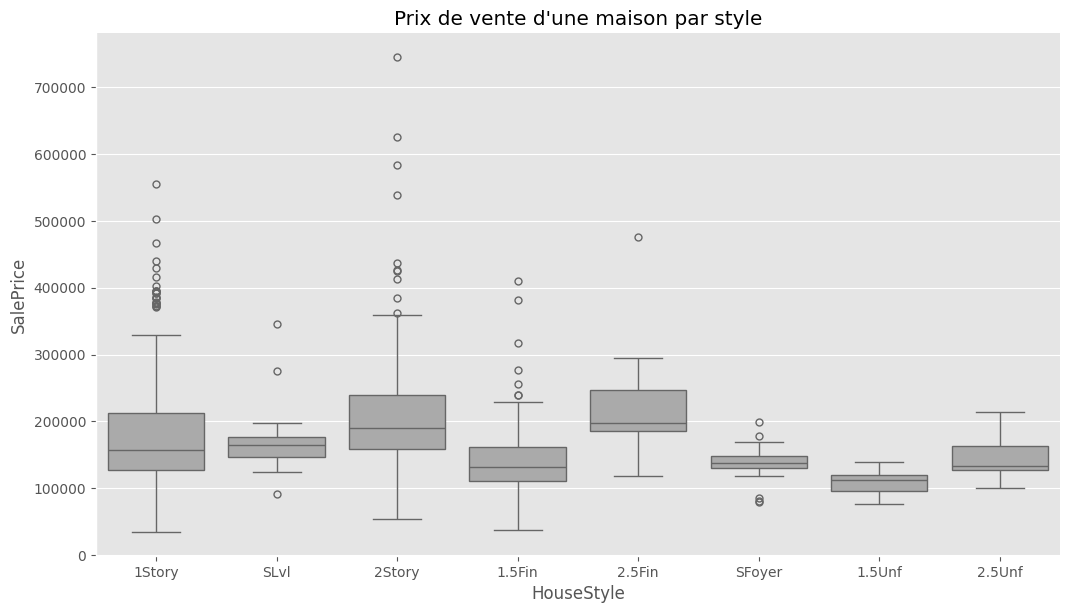

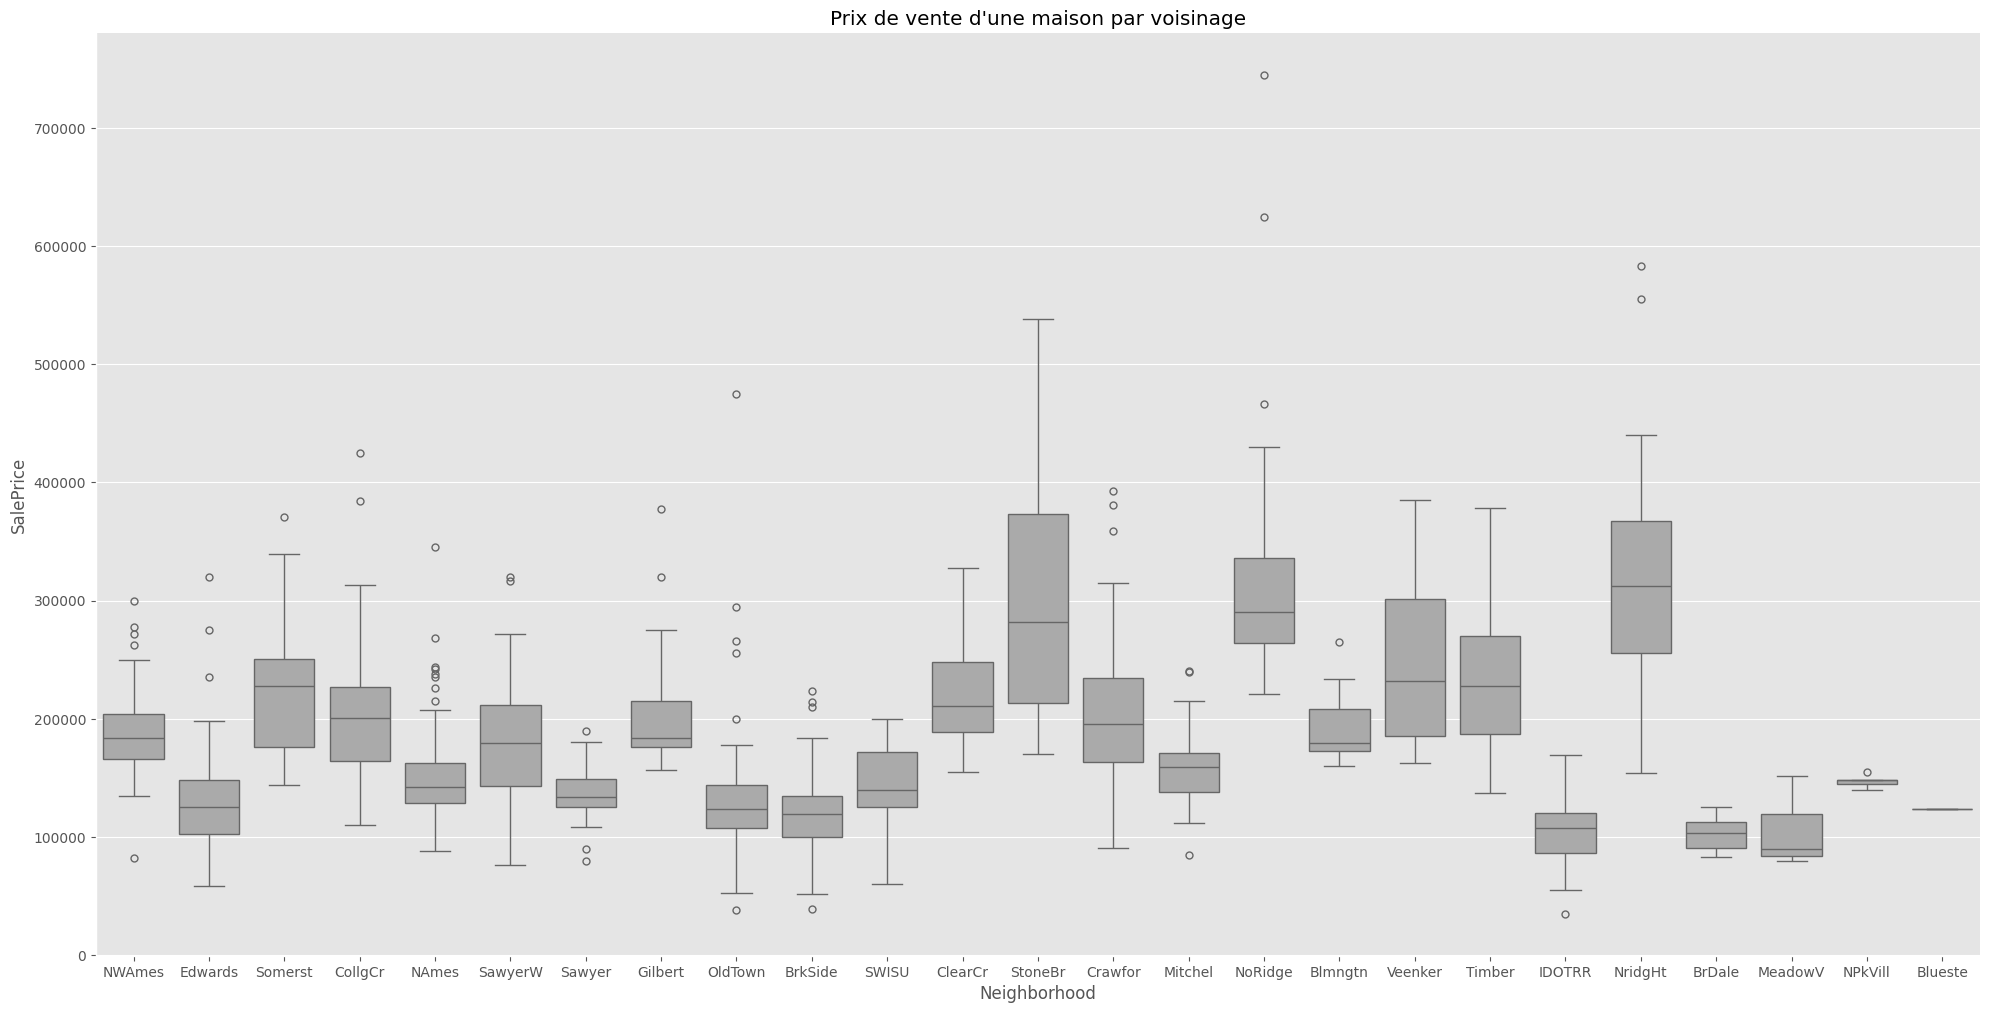

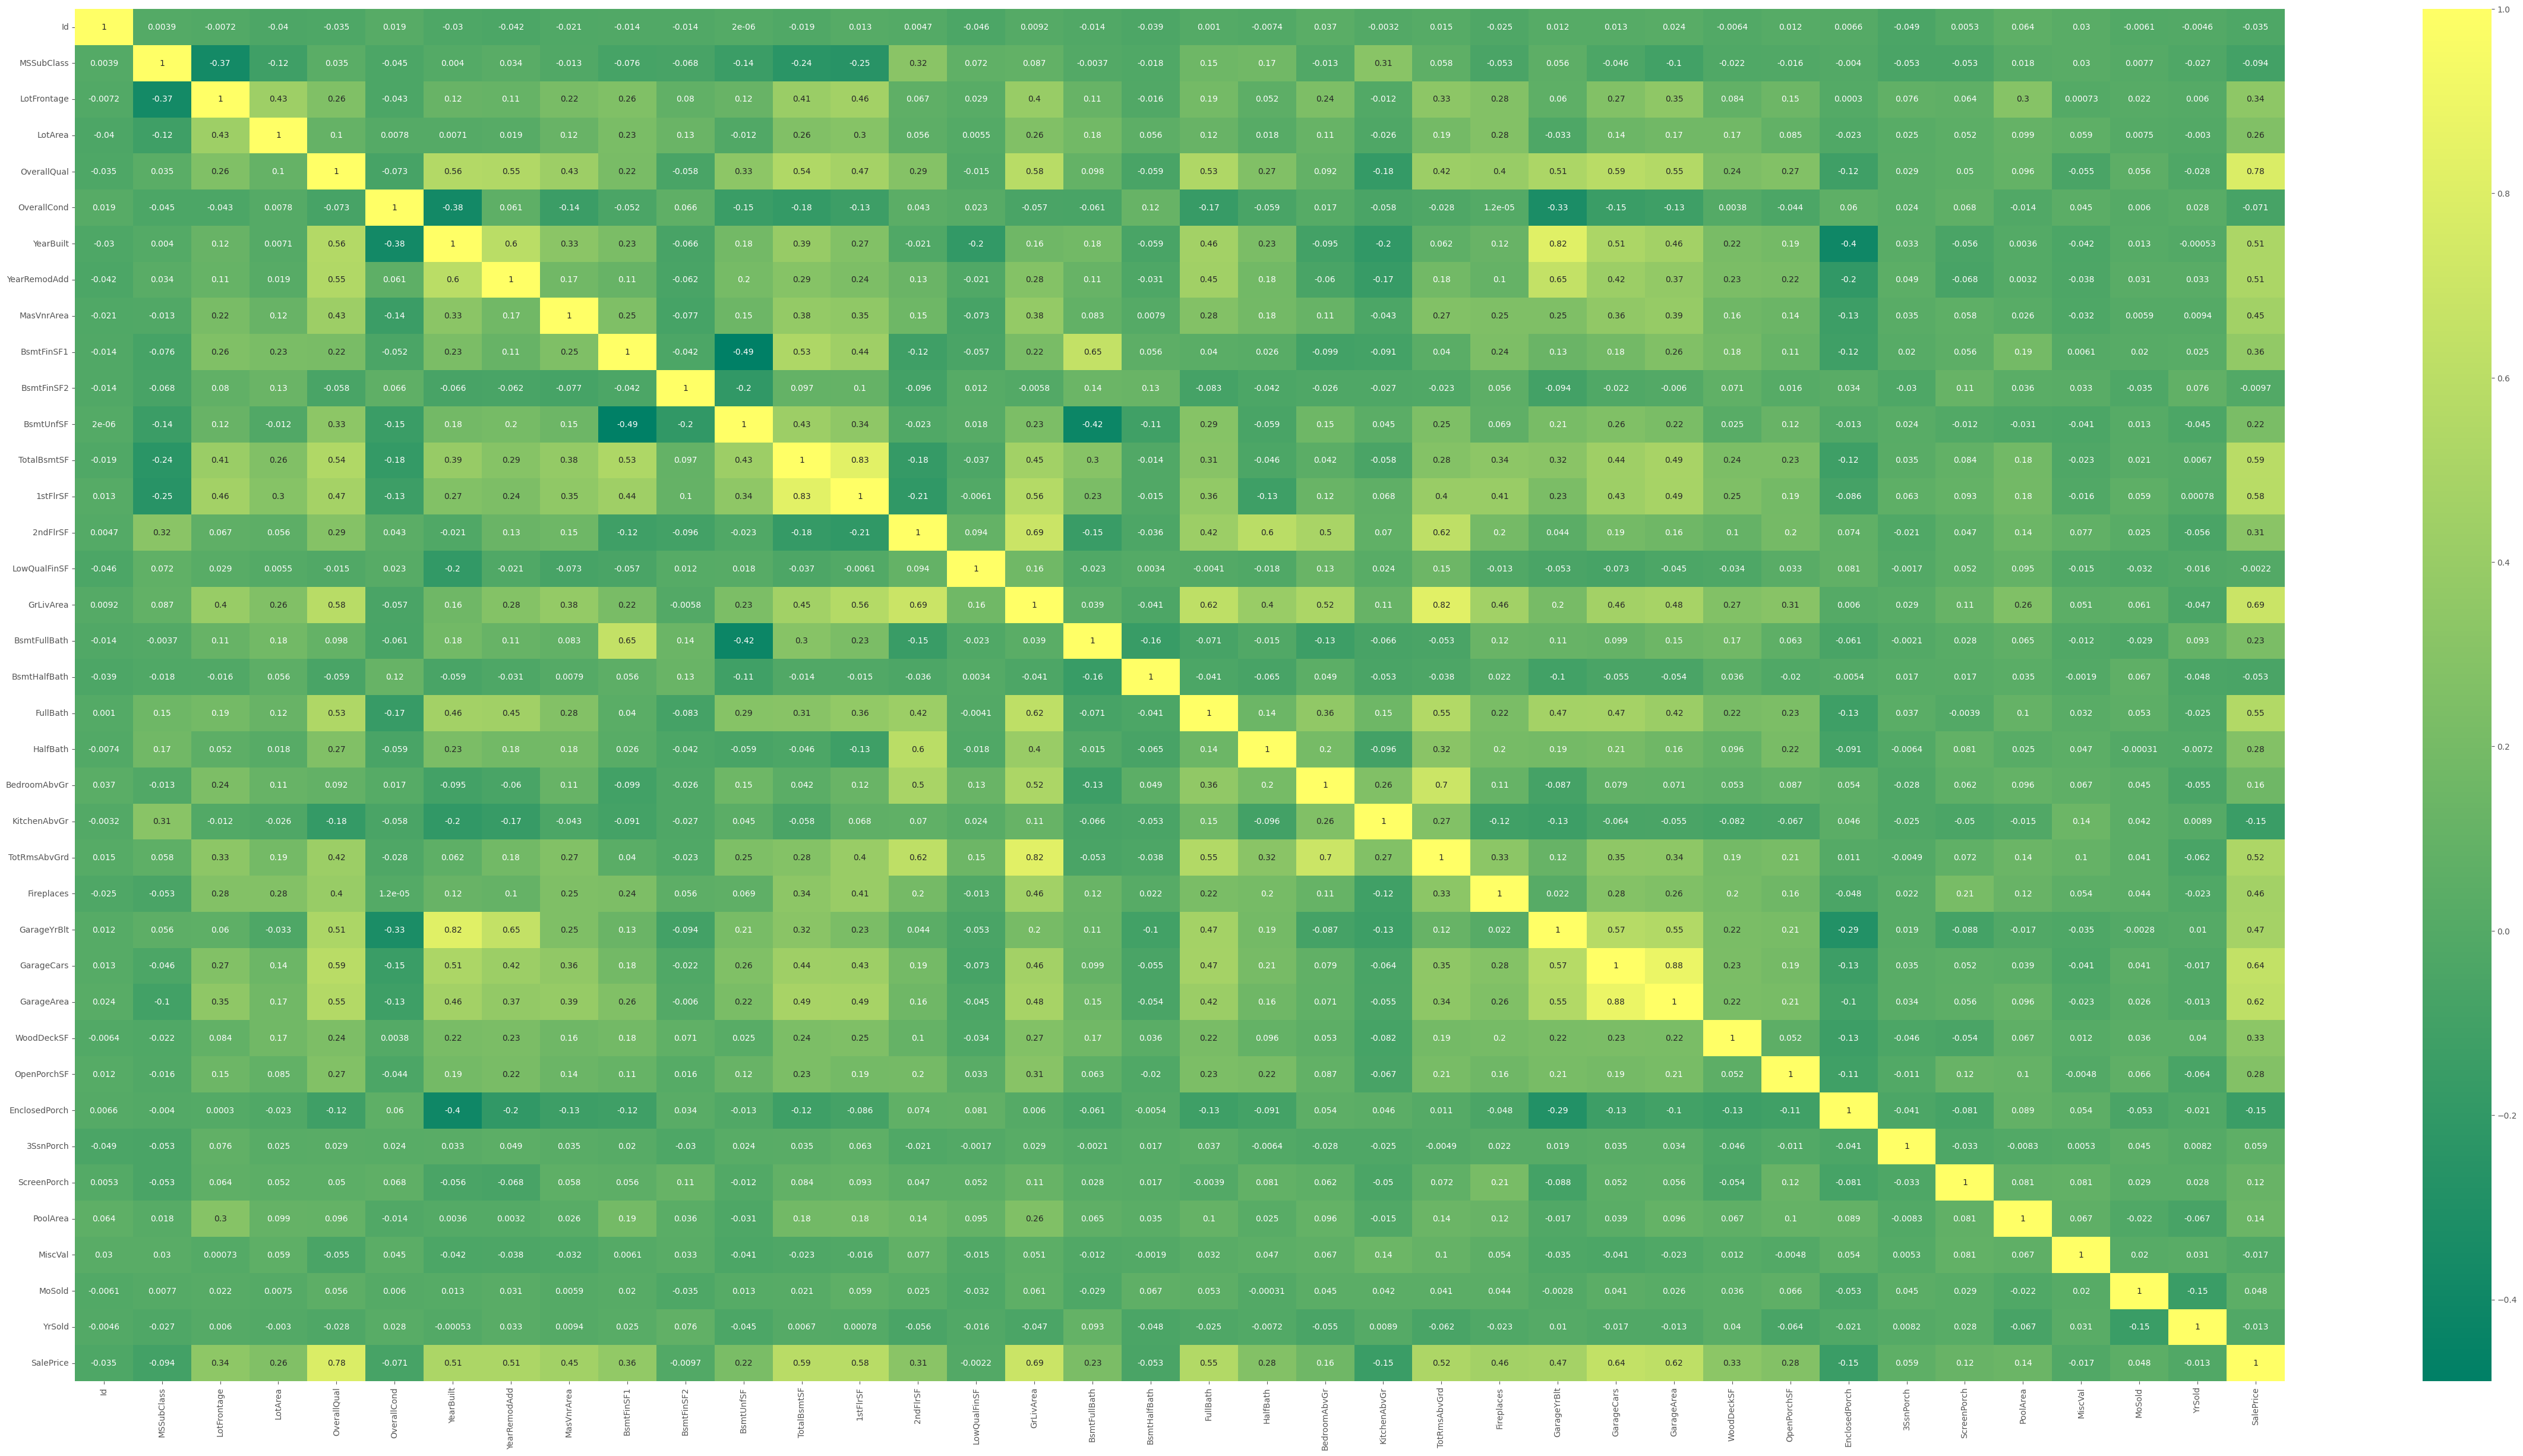

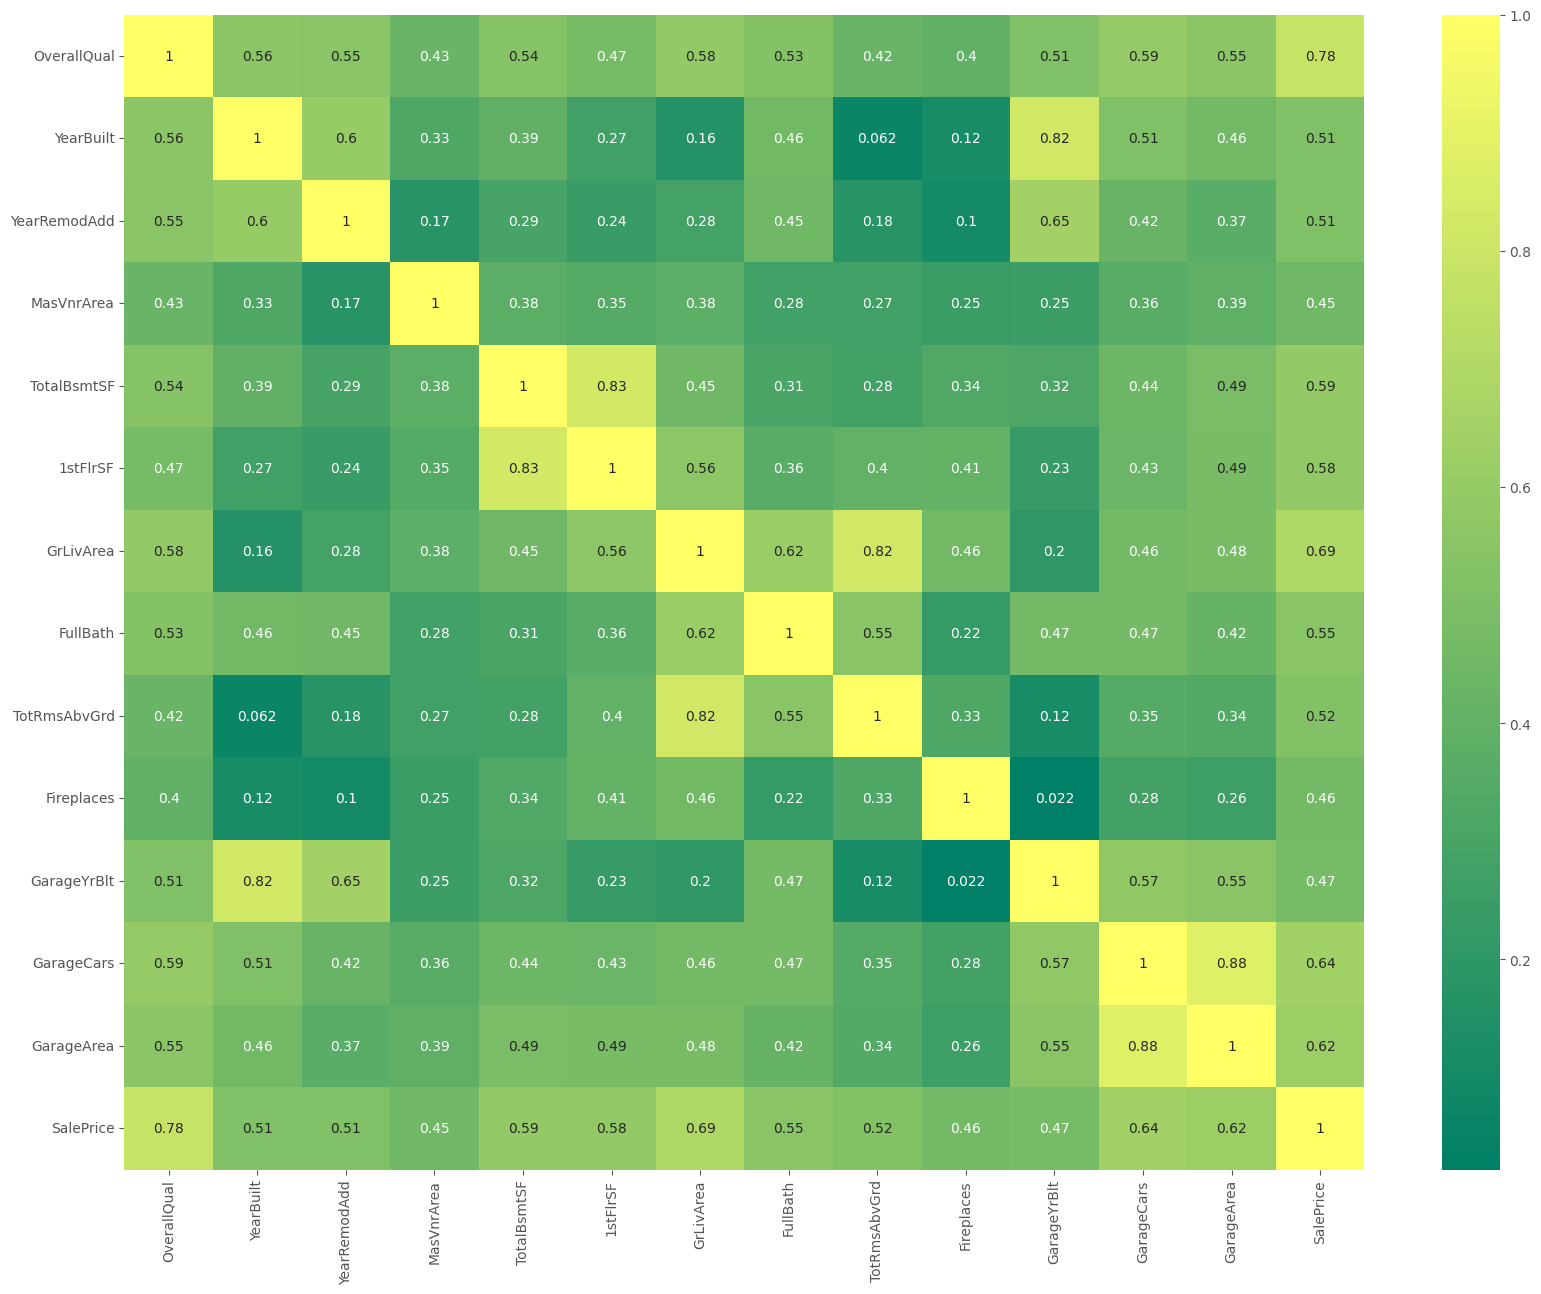

In [7]:
sns.catplot(x = "HouseStyle",
            y = "SalePrice",
            kind = "box",
            height = 6,
            aspect = 1.8,
            color = "#AAAA",
            data = train).set(title = "Prix de vente d'une maison par style");

sns.catplot(x = "Neighborhood",
            y = "SalePrice",
            kind = "box",
            height = 10,
            aspect = 2,
            color = "#AAAA",
            data = train).set(title = "Prix de vente d'une maison par voisinage");

# Analysons les correlations des variables
plt.figure(figsize=[60, 30])
sns.heatmap(train.select_dtypes(include='number').corr(), annot=True, cmap="summer")

# Ici, nous ne desirons pas les correlations negative ou juste faiblement positivement correlees.
# Nous etablirons un seuil de correlation superieur a 0.4 avec `SalePrice`

corr_thres = 0.4
corr_df = train.select_dtypes(include='number').corr()
high_corr_var = corr_df.index[abs(corr_df["SalePrice"]) > corr_thres]
plt.figure(figsize=(20,15))
sns.heatmap(train[high_corr_var].corr(), annot=True, cmap="summer")

train[high_corr_var].corr()


Nous pouvons voir que qu'il y a une grande correlation entre:

* `GarageYearBuilt` et `YearBuilt`
* `TotRmsAbvGrd` et `GrLivArea`
* `1stFlrSF` et `TotalBsmtSF`
* `GarageArea` et `GarageCars`

Nous pourrons effacer `1stFlrSF`, `GarageArea`, `TotRmsAbvGrd` et `GarageYrBlt`.


<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

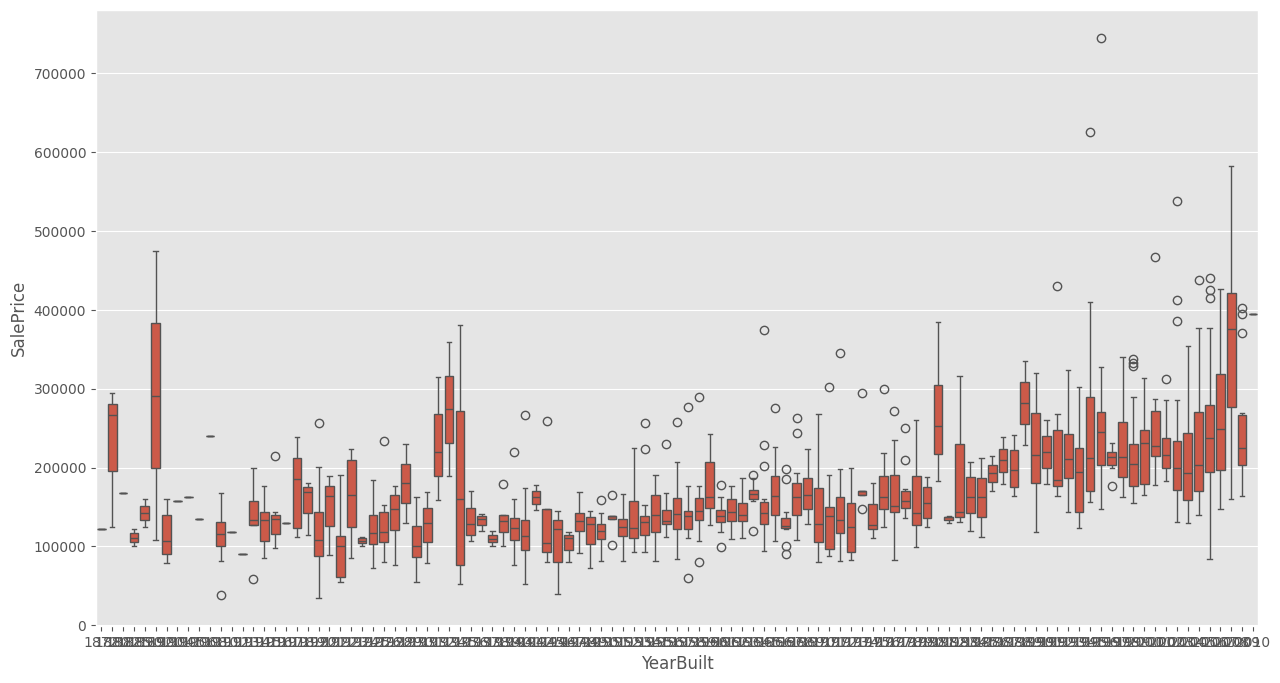

In [32]:
plt.figure(figsize=(15,8))
sns.boxplot(x=train.YearBuilt, y=train.SalePrice)

Il semble que les maison recemment construite aient un prix de vente plus eleve. Les donnes relatives a `Year` semblent etre une bonne indication de prix.

Inspectons le parametre `GrLivArea` et essayons de reperer les donnees aberrantes.

(0.0, 800000.0)

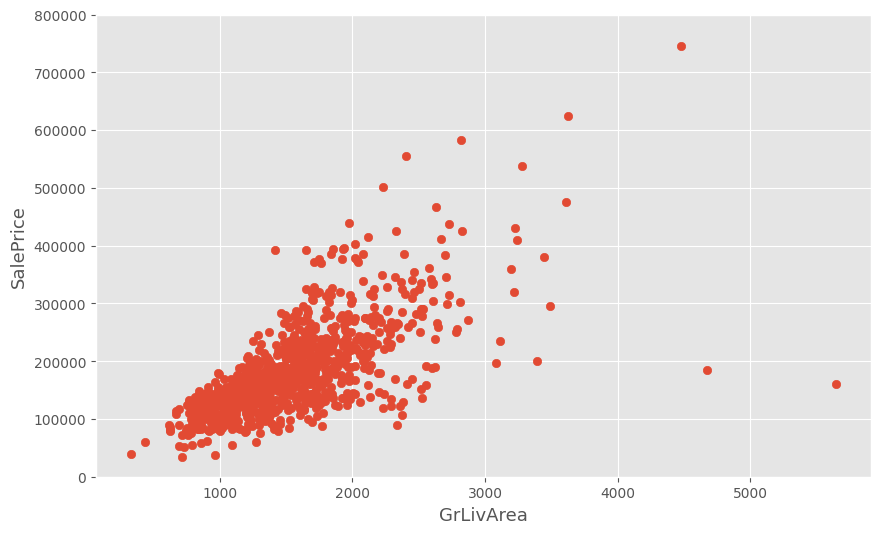

In [33]:
plt.figure(figsize=(10,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [37]:
# Retirons les donnees aberrantes
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)
full=pd.concat([train, test], ignore_index=True)
full.drop(['Id'],axis=1, inplace=True)
full.shape

(1458, 80)

In [38]:
# A present, essayons de reperer les valeurs nulles
aa = full.isnull().sum()
aa[aa>0].sort_values(ascending=False)

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

In [39]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        47.142857   43.0    14
Blueste        24.000000   24.0     2
BrDale         21.562500   21.0    16
BrkSide        57.509804   52.0    51
ClearCr        83.461538   80.0    13
CollgCr        71.682540   70.0   126
Crawfor        71.804878   74.0    41
Edwards        64.811111   64.5    90
Gilbert        79.877551   65.0    49
IDOTRR         62.500000   60.0    34
MeadowV        27.800000   21.0    15
Mitchel        70.083333   73.0    36
NAmes          76.462366   73.0   186
NPkVill        32.285714   24.0     7
NWAmes         81.288889   80.0    45
NoRidge        91.878788   91.0    33
NridgHt        81.881579   88.5    76
OldTown        62.788991   60.0   109
SWISU          58.913043   60.0    23
Sawyer         74.437500   71.0    48
SawyerW        71.500000   66.5    50
Somerst        64.666667   73.5    78
StoneBr        62.700000   61.5    20
Timber         80.133333   85.0    30
Veenker        59.714286   68.0     7

In [40]:
# Remplacons les donnees manquantes de `LotFrontage` en se basant sur la mediane de `LotArea` et `Neighborhood`.
# Comme `LotArea` est continue, nous utiliserons qcut to la diviser en 10 parties. 
full["LotAreaCut"] = pd.qcut(full.LotArea,10)
full.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 5000.0]    36.691057   35.0   123
(5000.0, 7071.2]      55.984252   52.0   127
(7071.2, 8063.1]      63.869919   61.0   123
(8063.1, 8788.8]      67.143939   65.0   132
(8788.8, 9475.0]      70.544715   70.0   123
(9475.0, 10193.0]     75.195312   76.0   128
(10193.0, 11049.9]    73.780488   75.0   123
(11049.9, 12194.6]    84.649123   84.5   114
(12194.6, 14340.9]    84.733945   85.0   109
(14340.9, 215245.0]   93.628866   90.0    97

In [41]:
## Remplacons d'autres valeurs manquantes en regardant la description des donnees fournies

full['LotFrontage']=full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [42]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)

cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

In [43]:
# Verifions qu'il n'y a plus de valeurs nulles
full.isnull().sum()[full.isnull().sum()>0]

Series([], dtype: int64)

In [44]:
#### Feature engineering

# Certaines valeurs numeriques pourrait etre converties dans des valeurs categoriques car elles ont tres peu de valeurs differentes

num_str = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in num_str:
    full[col]=full[col].astype(str)

In [45]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

In [46]:
### Cette fonction va convertir les valeurs categoriques en entier (une sorte de "Label encoder" pour ce set de donnees)
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})

In [47]:
map_values()

In [48]:
### Nous avons terminer le feature engineering, maintenant effacons les dernieres colonnes
# non desirees et creons notre pipeline de traitement de donnees

full.drop("LotAreaCut",axis=1,inplace=True)
full.drop(['SalePrice'],axis=1,inplace=True)

In [49]:
### Pipeline

class LabelEnc(BaseEstimator, TransformerMixin):
    """
    Conformement a ce que nous avios dit precedemment,
    Nous allons encoder les labels relatifs a `Year*`
    """
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X


class SkewDummies(BaseEstimator, TransformerMixin):
    """
    Certaines donnees sont asymetriques. Nous leurs appliquerons
    un logarithme naturel ainsi que `pd.get_dummies` pour convertir les categories
    en variables binaires
    """
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

# Creons notre pipeline
pipe = Pipeline([
    ('labenc', LabelEnc()),
    ('skew_dummies', SkewDummies(skew=1)),
])

# Nous voulons experimenter ce pipeline, nous creons une copie de notre jeu de donnees pour expimenter avec.
full2 = full.copy()
data_pipe = pipe.fit_transform(full2)
data_pipe.shape

(1458, 392)

In [50]:
data_pipe.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.394449  9.249657            7            6         71            20   
1     3.583519  8.209580            5            5        106            55   
2     4.290459  9.064274            7            5        110            59   
3     4.442651  9.364862            9            5        107            56   
4     3.784190  9.275004            7            6         97            46   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLw  \
0    5.666427           0    0.000000       1304  ...           False   
1    4.394449         547    0.000000          0  ...           False   
2    0.000000          24    0.000000        732  ...           False   
3    5.713733           0    0.000000       1905  ...           False   
4    0.000000         385    5.843544         70  ...            True   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0         False         False         True                  False   
1         False         False         True                  False   
2         False         False        False                  False   
3         False         False         True                  False   
4         False         False        False                  False   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                  False                 False                 False   
1                  False                 False                 False   
2                  False                 False                 False   
3                  False                 False                 False   
4                  False                 False                 False   

   SaleCondition_Normal  SaleCondition_Partial  
0                  True                  False  
1                  True                  False  
2                  True                  False  
3                  True                  False  
4                  True                  False  

[5 rows x 392 columns]

In [51]:
# Il pourrait y avoir d'autres donnees aberrantes. RobustScaler()
# permet de soustraire la mediane et diviser les valeurs d'une colonne par l'intervalle interquartile
# pour eliminer les valeurs aberrantes.
scaler = RobustScaler()
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

# Nous transformons le dataset avec le scaler et creons notre dataset test (test_X_scaled)
X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)


### Il y a encore beaucoup de parametres a analyser. Nous utiliserons un modele Lasso
# afin de determiner l'importance des autres features  a inclure dans le modele final.

lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

FI_lasso = pd.DataFrame({"Importance de la feature":lasso.coef_}, index=data_pipe.columns)
FI_lasso.sort_values("Importance de la feature",ascending=False)

Importance de la feature
GrLivArea                              0.137257
OverallQual                            0.097569
YearBuilt                              0.077448
Exterior1st_BrkFace                    0.072709
Functional_Typ                         0.066968
...                                         ...
BsmtFinType1_Unf                      -0.014051
SaleCondition_Abnorml                 -0.028185
BsmtCond_Fa                           -0.031960
CentralAir_N                          -0.037118
KitchenAbvGr_2                        -0.051122

[392 rows x 1 columns]

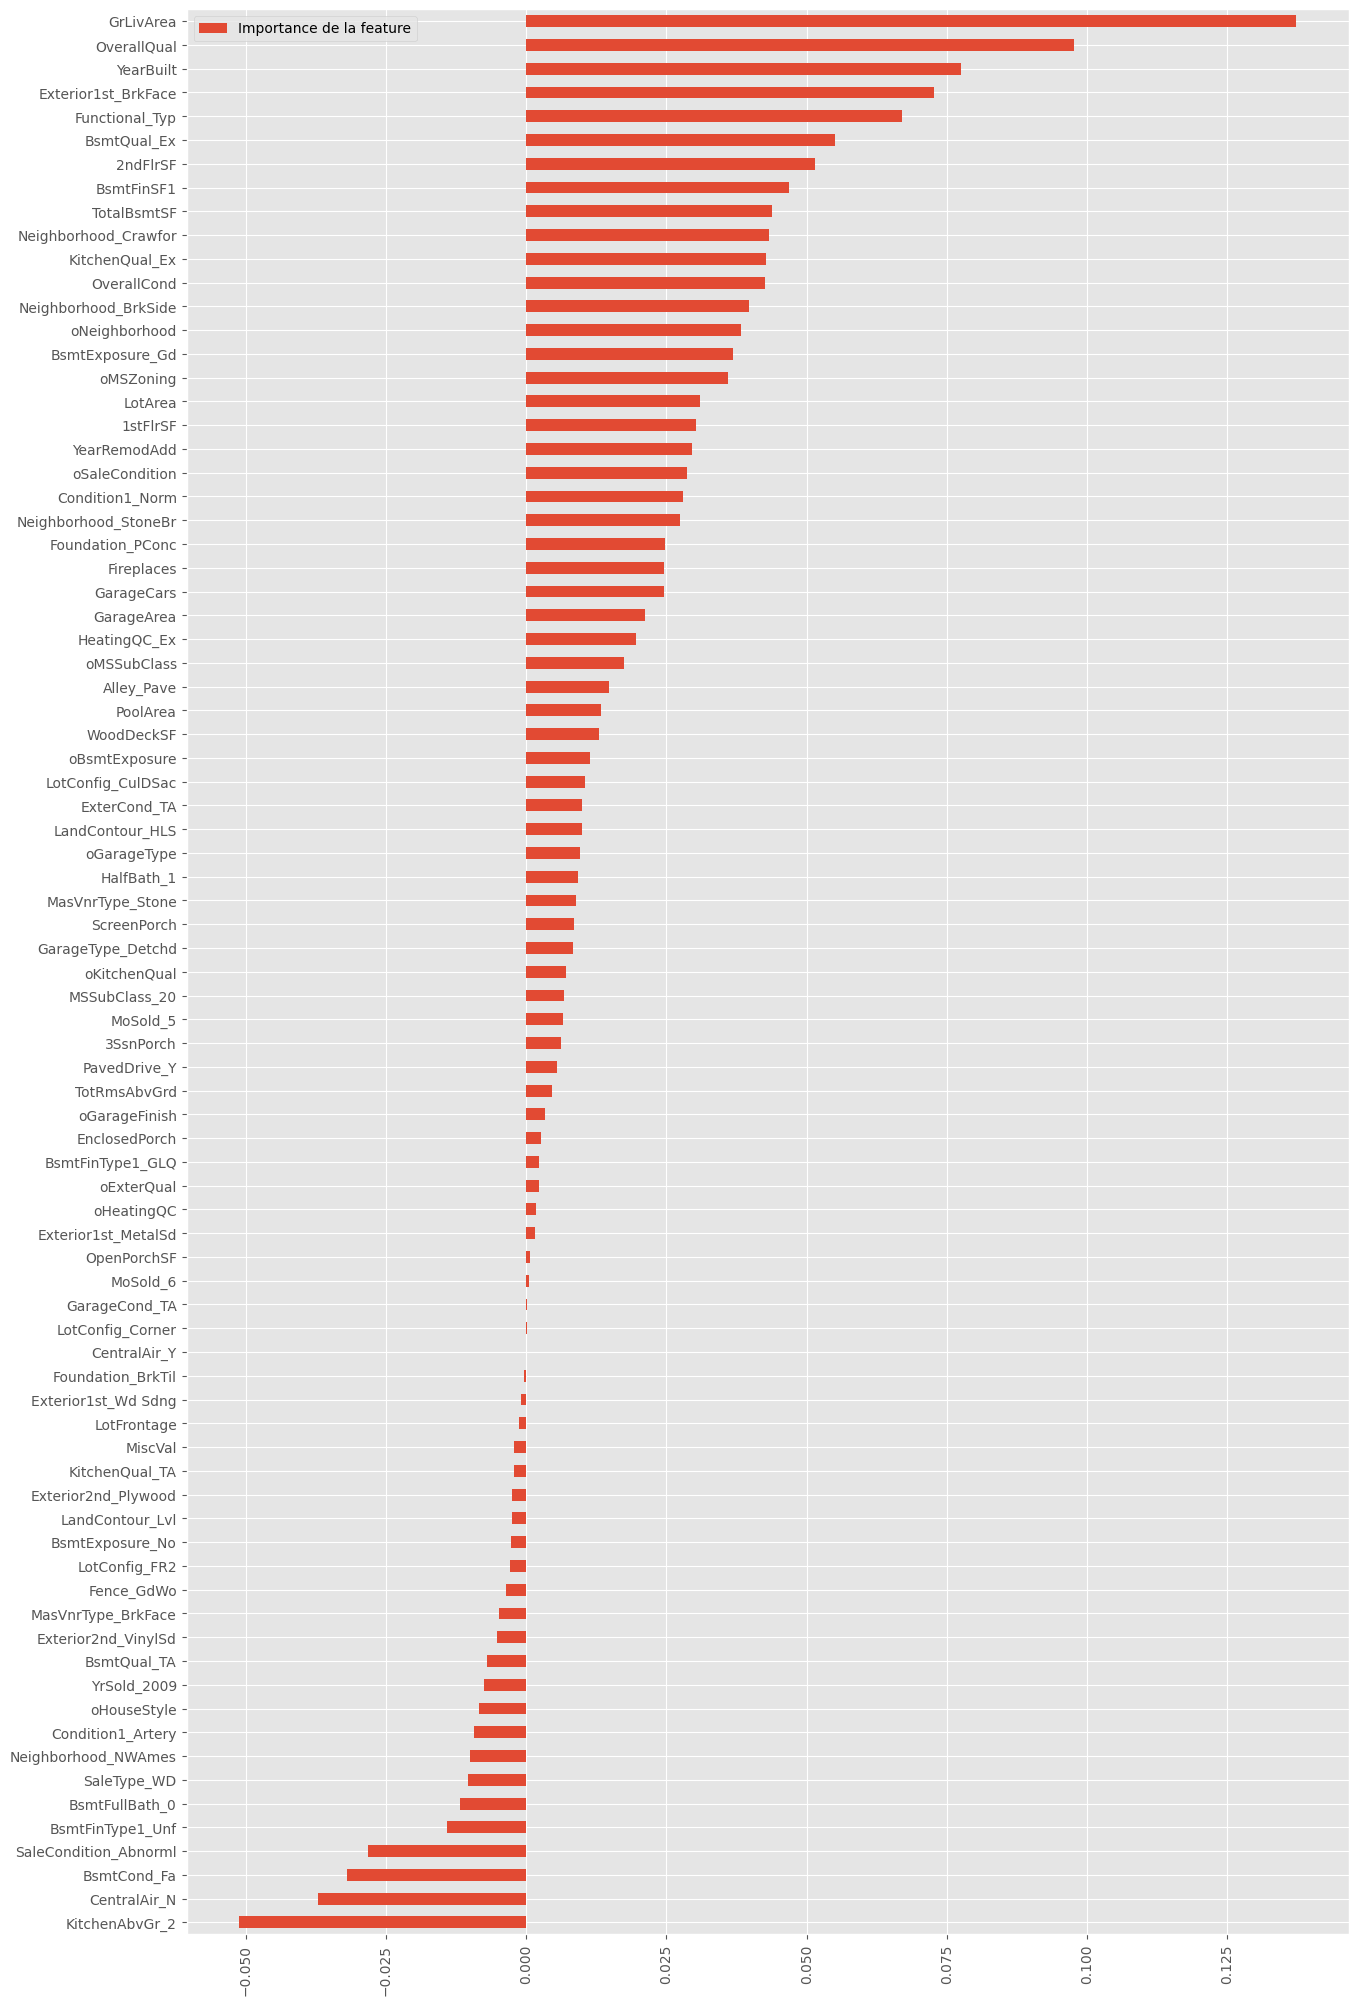

In [52]:
FI_lasso[FI_lasso["Importance de la feature"]!=0].sort_values("Importance de la feature").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [53]:
### Apres avoir analyse le graphiquue ci-dessus
# nous decidons d'ajouter une etape au pipeline
# permettant d'ajouter les features importantes
# au modele final

class AddFeature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [54]:
# Voici le pipeline final que nous utiliserons
pipe = Pipeline([
    ('labenc', LabelEnc()),
    ('add_feature', AddFeature(additional=2)),
    ('skew_dummies', SkewDummies(skew=1)),
])

In [55]:
full_pipe = pipe.fit_transform(full)
full_pipe.shape

(1458, 413)

In [56]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [57]:
## Apres quelques essaies decevant, nous realisons que beaucoup de features sont tres correlees entre elles.
# Nous utiliserons donc, une analyse par composante principales pour determiner ces correlations.
# Le but ici n'est pas la reduction de dimensions mais une simple analyse
# donc nous utiliserons approximativement la meme dimensionalite que le set de donne original..
pca = PCA(n_components=410)

In [58]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [59]:
X_scaled.shape, test_X_scaled.shape

((1020, 410), (438, 410))

In [60]:
### A present, nous allons finir par
# definir notre strategie de validation croisee.

# Nous utiliserons une erreur RMS pour le score de validation croisee (... en utilisant tous les coeur CPUs que nous avons :))
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5, n_jobs=-1))
    return rmse

# Nous testerons un ensemble de modeles presentes ci-dessous
models = [
    LinearRegression(),
    Ridge(),
    Lasso(alpha=0.01,max_iter=10000),
    RandomForestRegressor(verbose=True),
    GradientBoostingRegressor(verbose=True),
    SVR(verbose=True),
    LinearSVR(verbose=True),
    ElasticNet(alpha=0.001,max_iter=10000),
    SGDRegressor(max_iter=1000,tol=1e-3),
    BayesianRidge(),
    KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
    ExtraTreesRegressor(),
    XGBRegressor()
]

names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 21532291681.657513, 32317051780.8113
Ridge: 0.116926, 0.0052
Lasso: 0.121271, 0.0090
RF: 0.136215, 0.0110
GBR: 0.126103, 0.0091
*
optimization finished, #iter = 457
obj = -9.390973, rho = -12.085478
nSV = 248, nBSV = 8
*
optimization finished, #iter = 479
obj = -8.403193, rho = -12.124531
nSV = 257, nBSV = 4
*
optimization finished, #iter = 451
obj = -8.082057, rho = -12.145131
nSV = 239, nBSV = 4
*
optimization finished, #iter = 472
obj = -8.748443, rho = -12.122289
nSV = 264, nBSV = 6
*
optimization finished, #iter = 474
obj = -9.147095, rho = -12.089680
nSV = 263, nBSV = 6
SVR: 0.145751, 0.0128
...........................................................................................................................................................................................................................................................................................................................................................................................
optimizatio

In [61]:
# les scores de cross validation sont plutot satisfaisant.
# A present, appliquons cette approche sur le set d'entrainement
# en adpatant les hyper parametres des modeles avec une "recherche de grille"

class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

### Essayons maintenant de determiner la "moyenne"
# de ces modeles en moyennant leurs poids en un seul modele
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # pour chaque point, nous faisons une seul prediction par model en multipliant par le poids, et nous les accumulons
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))

        return w

lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

# Assignons les importances respectives des modeles en fonction de leurs scores dans
# la #recherche de grille"
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])
score = rmse_cv(weight_avg,X_scaled,y_log)
print(f"Model moyen: {score.mean()}")

# Mais nous pouvons moyenner seulement les deux meilleurs models et ameliorer notre score de validation croisee.
weight_avg = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])

# Finalement, nous avons des performance decentes avec le modele suivant
avg_model = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])
score = rmse_cv(avg_model, X_scaled, y_log)
print(score.mean()) # ~ 0,1066

# Nous pouvons maintenant predire les valeurs de notre dataset test
pred = np.exp(avg_model.predict(test_X_scaled))
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})

{'alpha': 0.0007, 'max_iter': 10000} 0.11225241801455524
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.112371        0.001208
1  {'alpha': 0.0005, 'max_iter': 10000}         0.112274        0.001258
2  {'alpha': 0.0007, 'max_iter': 10000}         0.112252        0.001325
3  {'alpha': 0.0009, 'max_iter': 10000}         0.112372        0.001396
{'alpha': 35} 0.1095160067018446
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.109516        0.001293
1  {'alpha': 40}         0.109594        0.001318
2  {'alpha': 45}         0.109680        0.001342
3  {'alpha': 50}         0.109772        0.001364
4  {'alpha': 55}         0.109867        0.001385
5  {'alpha': 60}         0.109963        0.001405
6  {'alpha': 65}         0.110061        0.001425
7  {'alpha': 70}         0.110159        0.001443
8  {'alpha': 80}         0.110355        0.001479
9  {'alpha': 90}         0.110551        0.00